<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/lstm_univariate_timeseries_anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
%matplotlib inline
%config InlineBackend.figure_format='retina'
import pickle
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 15, 7

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.set_index("Time",inplace=True)
df.index = pd.to_datetime(df.index)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")

df.head()

,vibx,vibz,temp,zacc,crest,zfreq
Time,,,,,,
2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902


# Train Test 

In [15]:
def pickle_all(key,value):
         pickle_out = open(key, "wb")
         pickle.dump(value, pickle_out)
         pickle_out.close()

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [52]:
def lstm_anomaly(df,col,date,time_step,threshold):
    print(f"{col}"+50*"*")
    
    
    df1=df[[col]]
    train_size=len(df[df.index < date][col].tolist())
    test_size=df.shape[0]-train_size
    train, test = df1.iloc[0:train_size], df1[df1.index<"2020-01-27 15:00:00"]
    print(train.shape, test.shape)
    # reshape into X=t,t+1,t+2,t+3 and Y=t+4
    

    scaler = StandardScaler()
    scaler = scaler.fit(train[[col]])

    train[col] = scaler.transform(train[[col]])
    test[col] = scaler.transform(test[[col]])
    pickle_all(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_scaler_lstm_univarate.pkl",scaler)    
           
    TIME_STEPS = time_step
    
    # reshape to [samples, time_steps, n_features]

    X_train, y_train = create_dataset(train[[col]], train[col], TIME_STEPS)
    X_test, y_test = create_dataset(test[[col]], test[col], TIME_STEPS)

    print(X_train.shape)

    model = keras.Sequential()
    model.add(keras.layers.LSTM(
            units=64, 
            input_shape=(X_train.shape[1], X_train.shape[2])
        ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
    model.compile(loss='mae', optimizer='adam')
        
    history = model.fit(
        X_train, y_train,
        epochs=500,
        batch_size=32,
        validation_split=0.1,
        shuffle=False,verbose=1
    )
   
    model.save(f"/content/drive/MyDrive/model_predictive_maintanence/{col}_anomaly_model.h5")
    X_train_pred = model.predict(X_train)

    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
    
    X_test_pred = model.predict(X_test)

    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
    
    THRESHOLD = threshold

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df[col] = test[TIME_STEPS:][col]
    
    anomalies = test_score_df[test_score_df.anomaly == True]
    
    train_score_df = pd.DataFrame(index=train[TIME_STEPS:].index)
    train_score_df['loss'] = train_mae_loss
    train_score_df['threshold'] = THRESHOLD
    train_score_df['anomaly'] = train_score_df.loss > train_score_df.threshold
    train_score_df[col] = train[TIME_STEPS:][col]
    
    anomalies_train = train_score_df[train_score_df.anomaly == True]
    
    return anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler

In [53]:
def loss_and_threshold_value_plot():
    plt.plot(test_score_df.index, test_score_df.loss, label='loss_'+col)
    plt.plot(test_score_df.index, test_score_df.threshold, label='threshold_'+col)
    plt.xticks(rotation=25)
    plt.legend();

In [54]:
def train_mae_loss():
    sns.distplot(train_mae_loss, bins=50, kde=True);


In [55]:
def anomaly_plot(test,anomalies):
    print(anomalies.head(10))
    plt.plot(
          test[TIME_STEPS:].index, 
          scaler.inverse_transform(test[TIME_STEPS:][col]), 
          label=col
        );

    sns.scatterplot(
          anomalies.index,
          scaler.inverse_transform(anomalies[col]),
          color=sns.color_palette()[3],
          s=52,
          label='anomaly_'+col
        )
    plt.xticks(rotation=25)
    plt.legend();

In [56]:
def loss_plot():
    plt.plot(history.history['loss'], label='train loss_'+col)
    plt.plot(history.history['val_loss'], label='test loss_'+col)
    plt.legend();


In [57]:
total_anomalies = pd.DataFrame()


# vibx 

In [58]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="vibx",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

vibx**************************************************
(196, 1) (255, 1)
(176, 20, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/500
5/5 [==============================] - 3s 166ms/step - loss: 0.7564 - val_loss: 0.2940
Epoch 2/500
5/5 [==============================] - 0s 17ms/step - loss: 0.6604 - val_loss: 0.1928
Epoch 3/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5787 - val_loss: 0.1864
Epoch 4/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5578 - val_loss: 0.1729
Epoch 5/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5340 - val_loss: 0.1852
Epoch 6/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5350 - val_loss: 0.1803
Epoch 7/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5096 - val_loss: 0.1737
Epoch 8/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4891 - val_loss: 0.1742
Epoch 9/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4795 - val_loss: 0.1762
Epoch 10/500
5/5 [==============================] - 0s 16ms/step - loss: 0.4662 - val_loss: 0.1796
Epoch 11/500
5/5 [

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


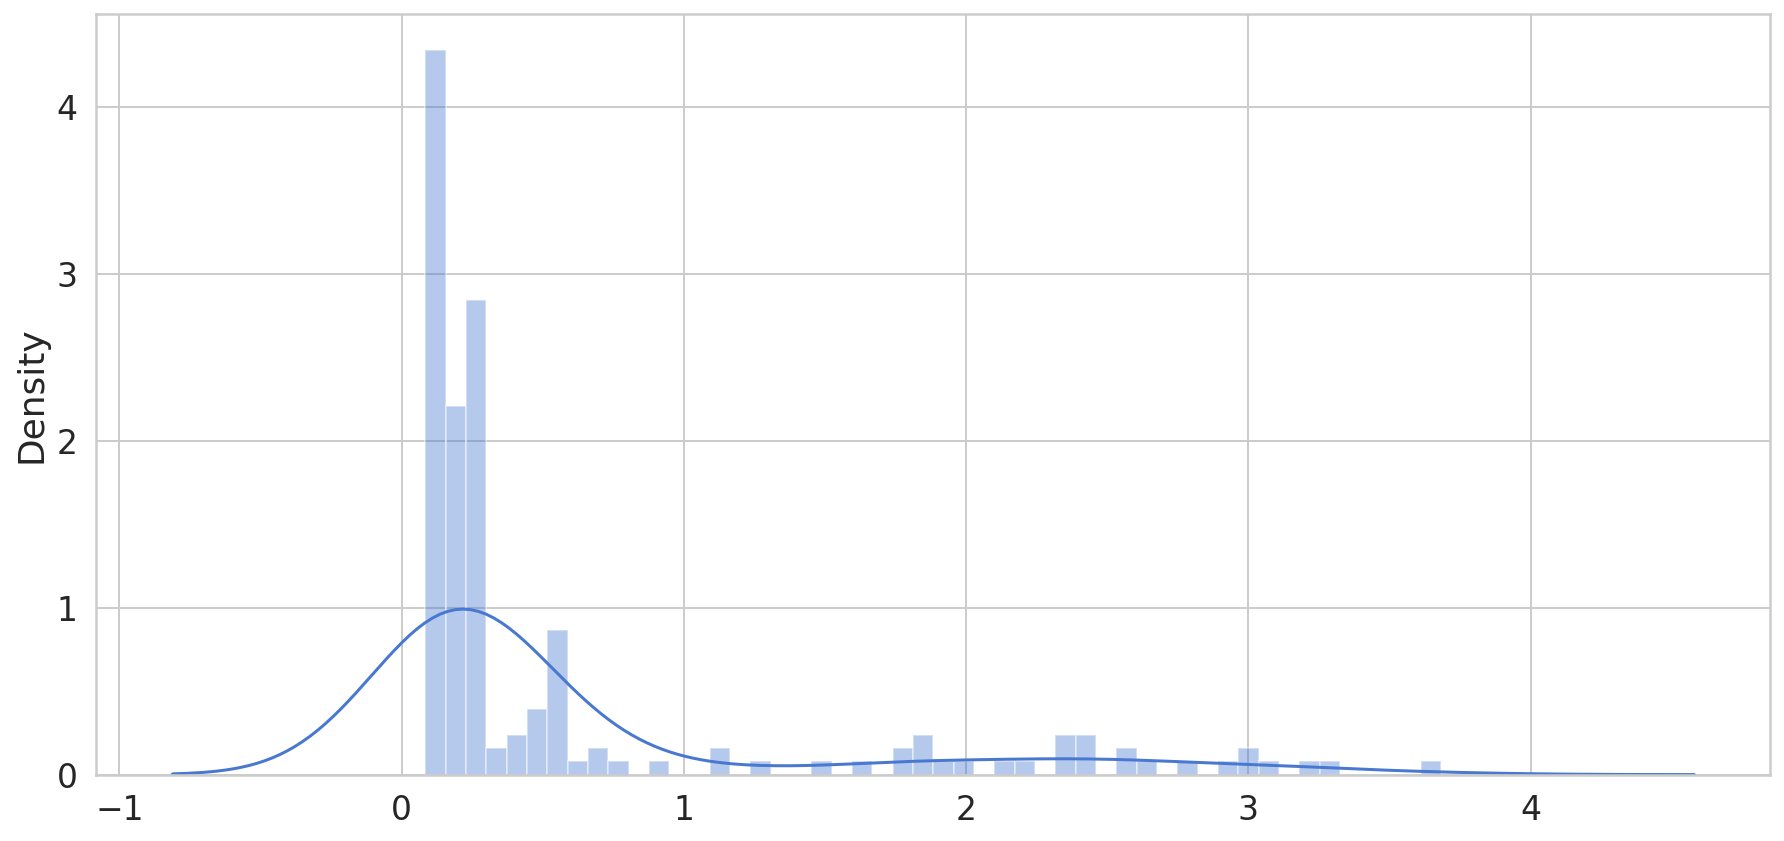

In [25]:
sns.distplot(train_mae_loss, bins=50, kde=True)

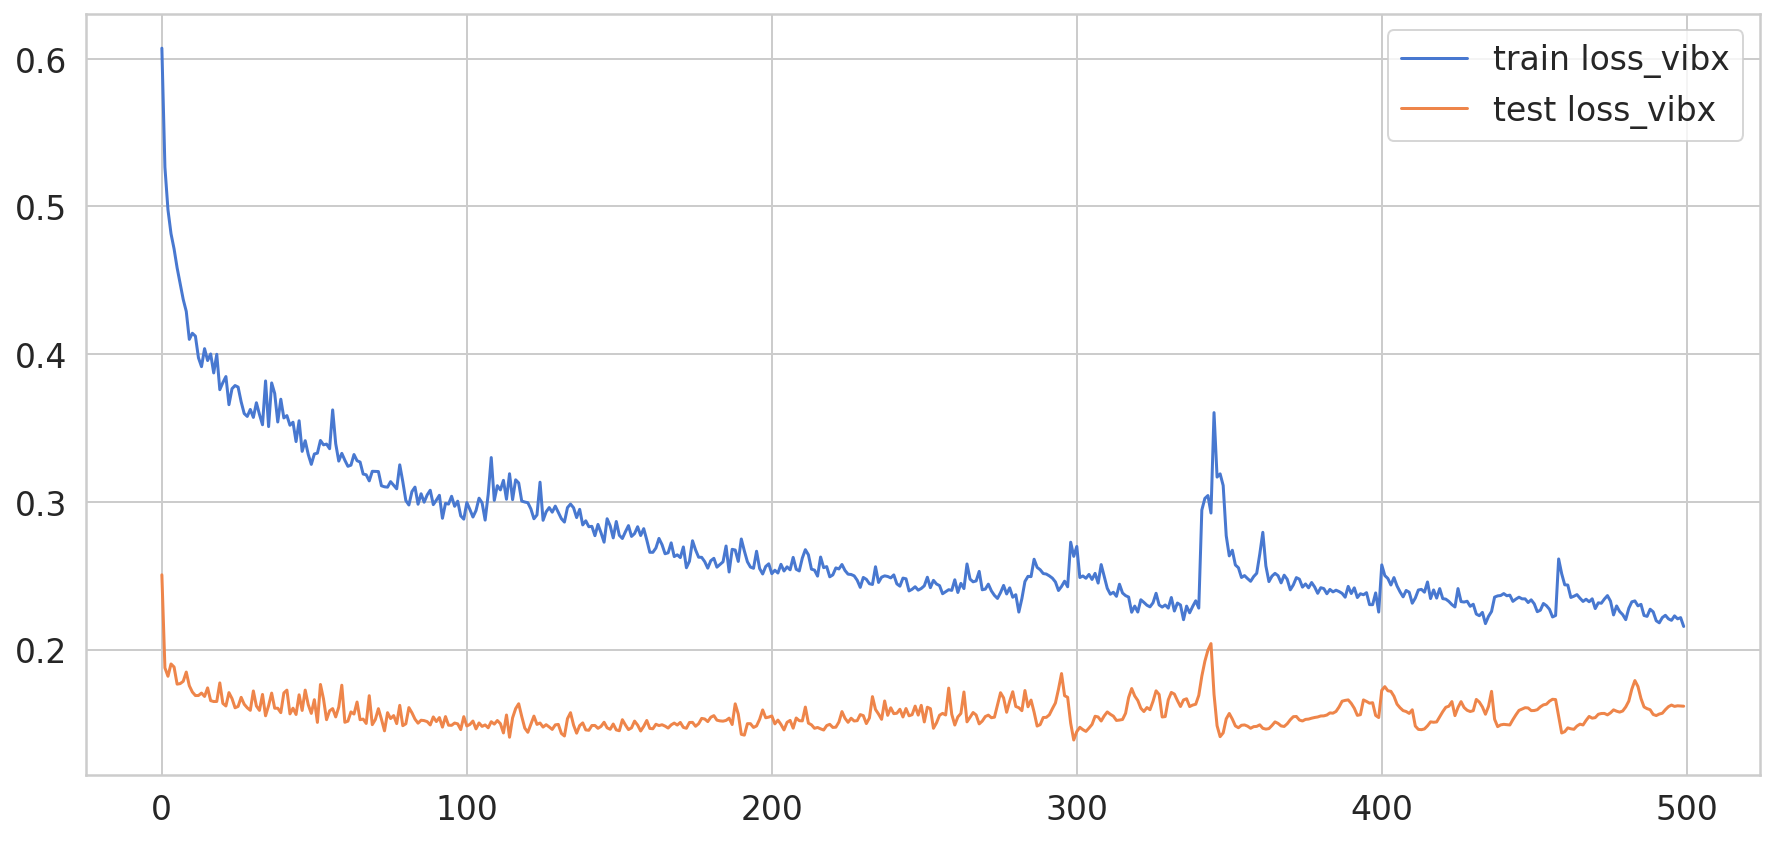

In [26]:
loss_plot()

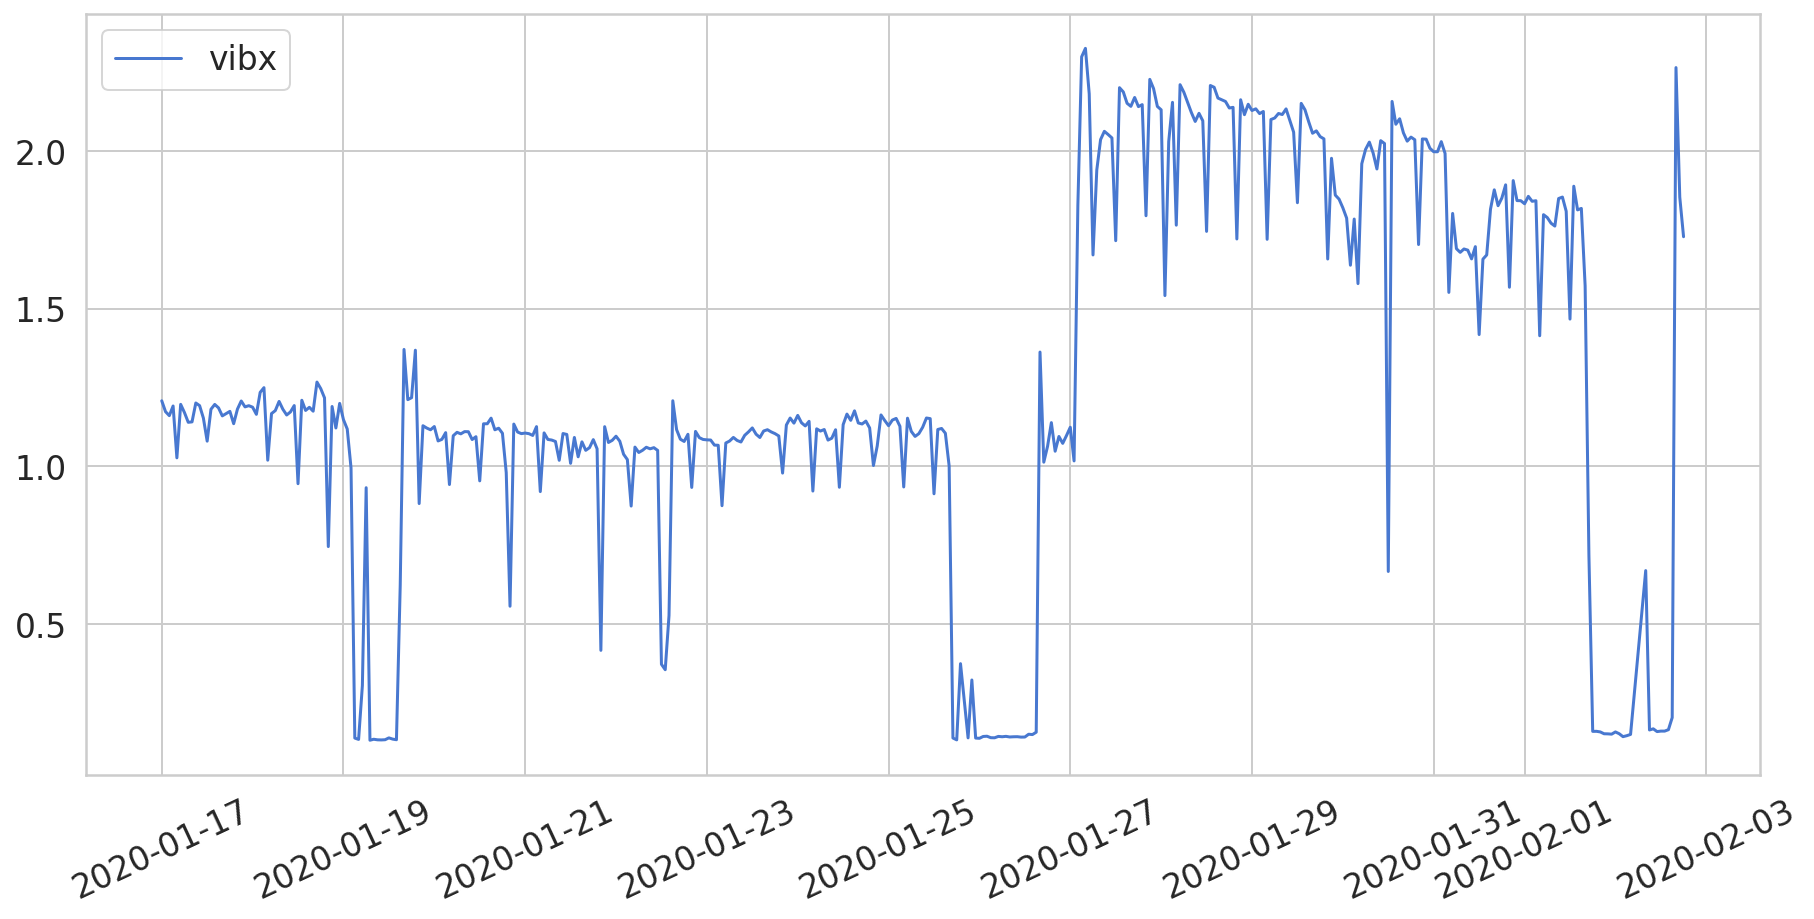

In [27]:
col_timeseries_plot()

                         loss  threshold  anomaly      vibx
Time                                                       
2020-01-19 04:00:00  3.684187        3.1     True -3.534243
2020-01-19 07:00:00  3.302614        3.1     True -3.544290
2020-01-19 08:00:00  3.106438        3.1     True -3.532303
2020-01-19 16:00:00  3.234337        3.1     True  1.308521
2020-01-25 18:00:00  3.281951        3.1     True -3.540009
2020-01-26 08:00:00  3.811504        3.1     True -3.504003
2020-01-26 10:00:00  3.500251        3.1     True -3.500447
2020-01-26 11:00:00  4.350807        3.1     True -3.505705
2020-01-26 12:00:00  4.602745        3.1     True -3.504576
2020-01-26 13:00:00  4.770475        3.1     True -3.469989


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


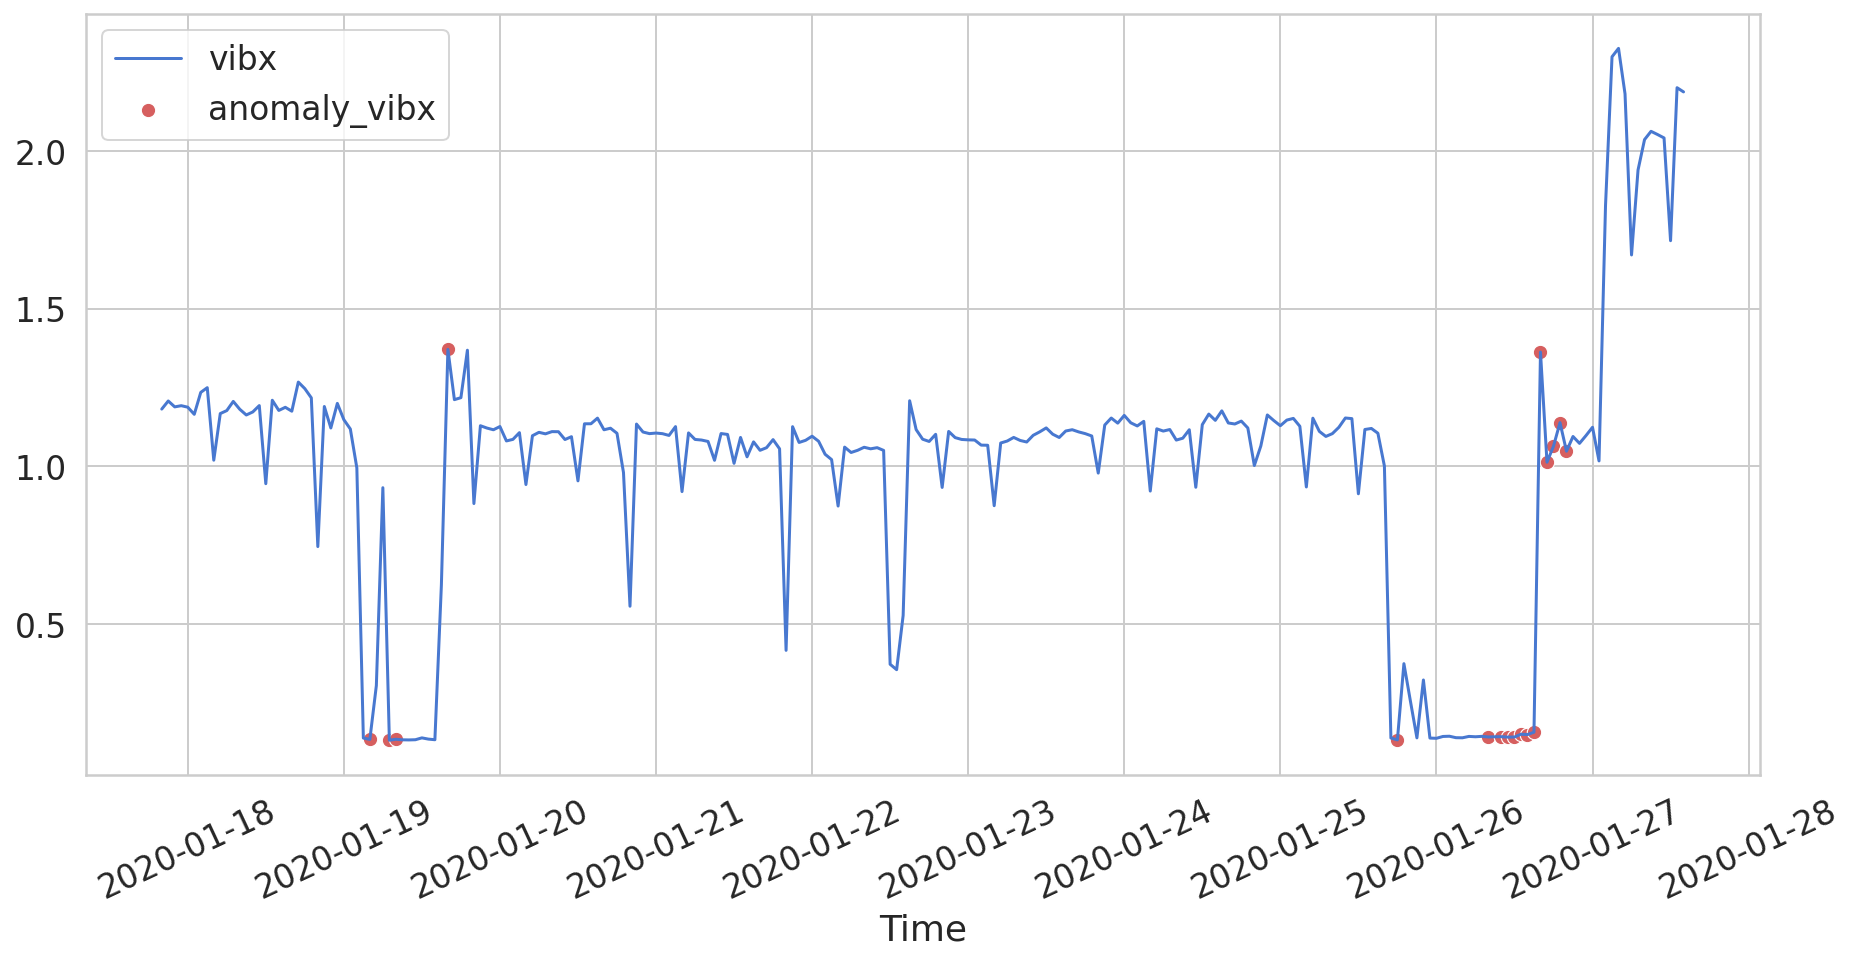

In [28]:
anomaly_plot(test,anomalies=anomalies)

# vibz

In [29]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="vibz",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

vibz**************************************************
(196, 1) (255, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(176, 20, 1)
Epoch 1/500
5/5 [==============================] - 3s 169ms/step - loss: 0.6870 - val_loss: 0.2172
Epoch 2/500
5/5 [==============================] - 0s 15ms/step - loss: 0.6084 - val_loss: 0.2354
Epoch 3/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5859 - val_loss: 0.2381
Epoch 4/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5765 - val_loss: 0.2310
Epoch 5/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5455 - val_loss: 0.2345
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5272 - val_loss: 0.2405
Epoch 7/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5207 - val_loss: 0.2454
Epoch 8/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5091 - val_loss: 0.2443
Epoch 9/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5078 - val_loss: 0.2419
Epoch 10/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4841 - val_loss: 0.2431
Epoch

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


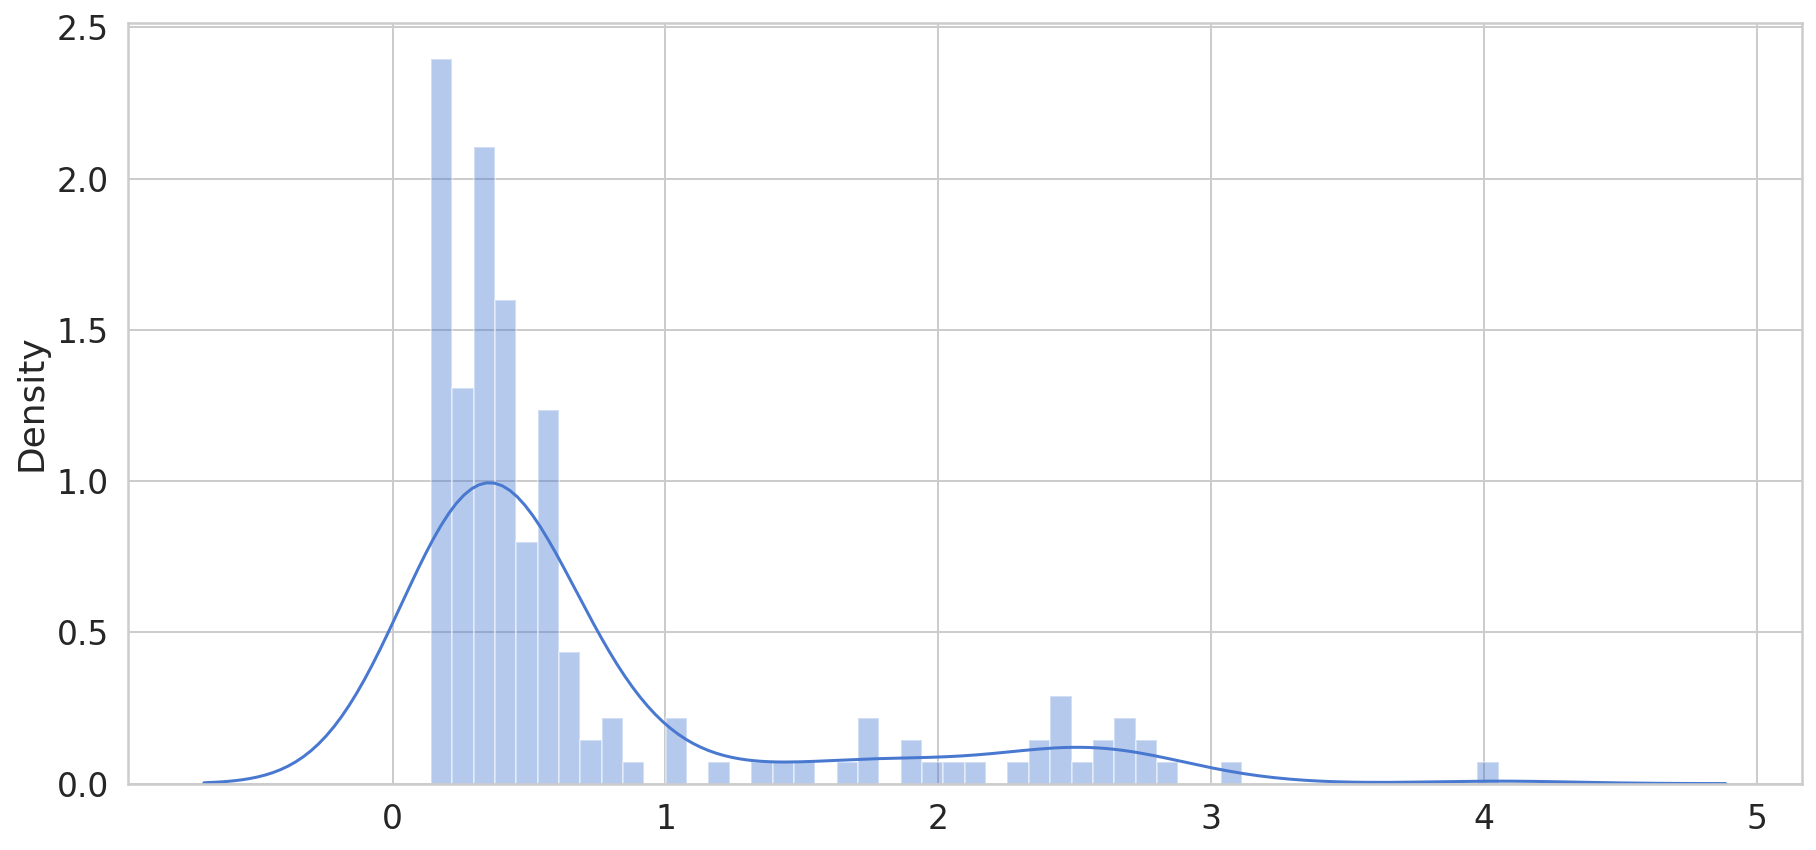

In [30]:
sns.distplot(train_mae_loss, bins=50, kde=True)

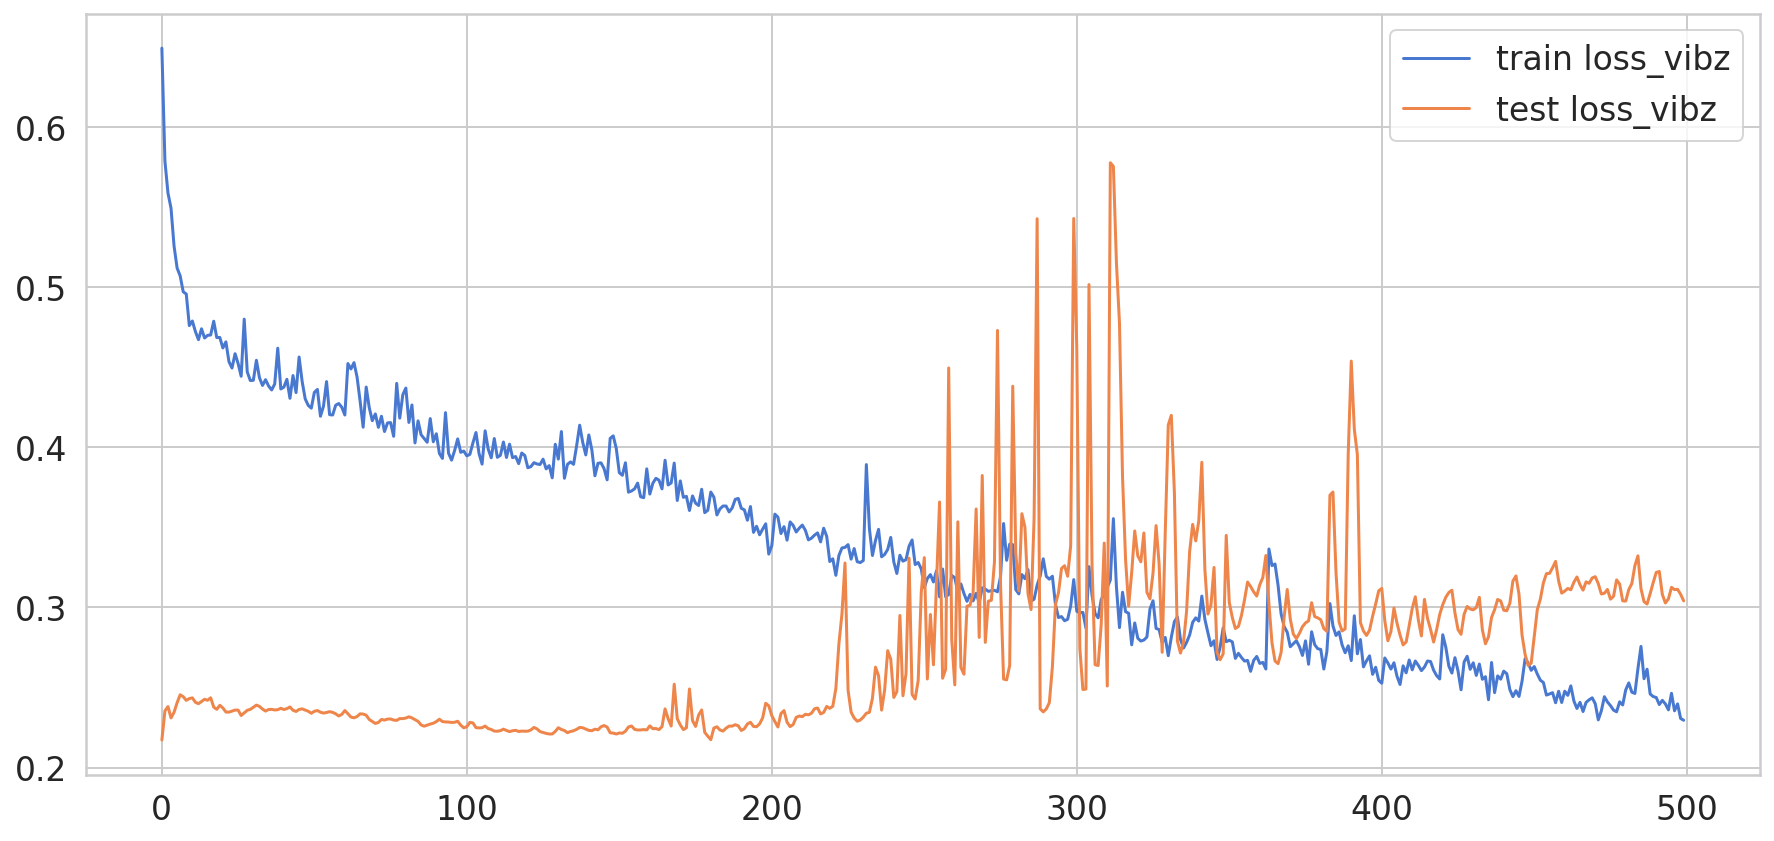

In [31]:
loss_plot()

                         loss  threshold  anomaly      vibz
Time                                                       
2020-01-19 16:00:00  4.053144        3.1     True  2.083871
2020-01-26 17:00:00  3.898644        3.1     True -0.480654
2020-01-26 18:00:00  3.849365        3.1     True -0.275772
2020-01-26 19:00:00  4.160927        3.1     True -0.121420
2020-01-26 20:00:00  3.954985        3.1     True -0.252659
2020-01-26 21:00:00  3.819343        3.1     True  0.242511
2020-01-26 22:00:00  3.469207        3.1     True -0.082579
2020-01-26 23:00:00  3.394183        3.1     True -0.023441
2020-01-27 00:00:00  3.270786        3.1     True -0.298001


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


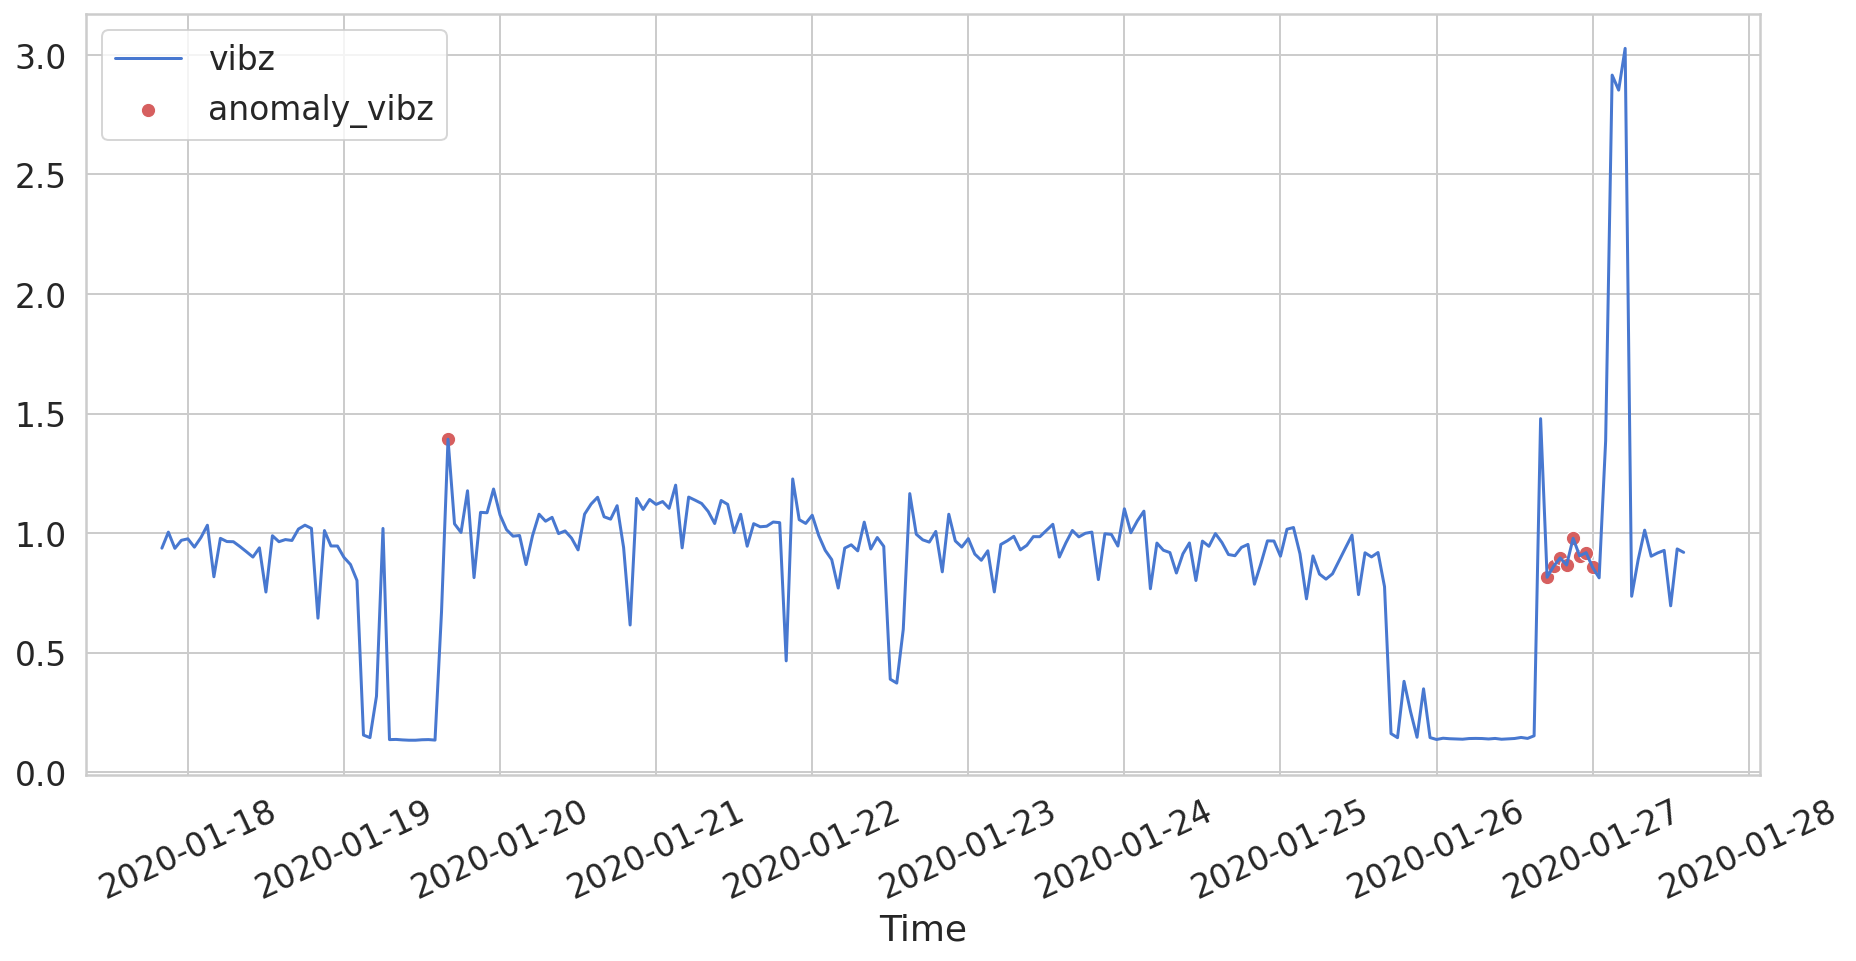

In [32]:
anomaly_plot(test,anomalies=anomalies)

# temp

In [33]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="temp",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

temp**************************************************
(196, 1) (255, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(176, 20, 1)
Epoch 1/500
5/5 [==============================] - 3s 161ms/step - loss: 0.6710 - val_loss: 0.3788
Epoch 2/500
5/5 [==============================] - 0s 17ms/step - loss: 0.5864 - val_loss: 0.3118
Epoch 3/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5228 - val_loss: 0.2523
Epoch 4/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5081 - val_loss: 0.2341
Epoch 5/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4819 - val_loss: 0.2249
Epoch 6/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4751 - val_loss: 0.2217
Epoch 7/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4526 - val_loss: 0.2292
Epoch 8/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4316 - val_loss: 0.2287
Epoch 9/500
5/5 [==============================] - 0s 16ms/step - loss: 0.4173 - val_loss: 0.2173
Epoch 10/500
5/5 [==============================] - 0s 15ms/step - loss: 0.3981 - val_loss: 0.2093
Epoch

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


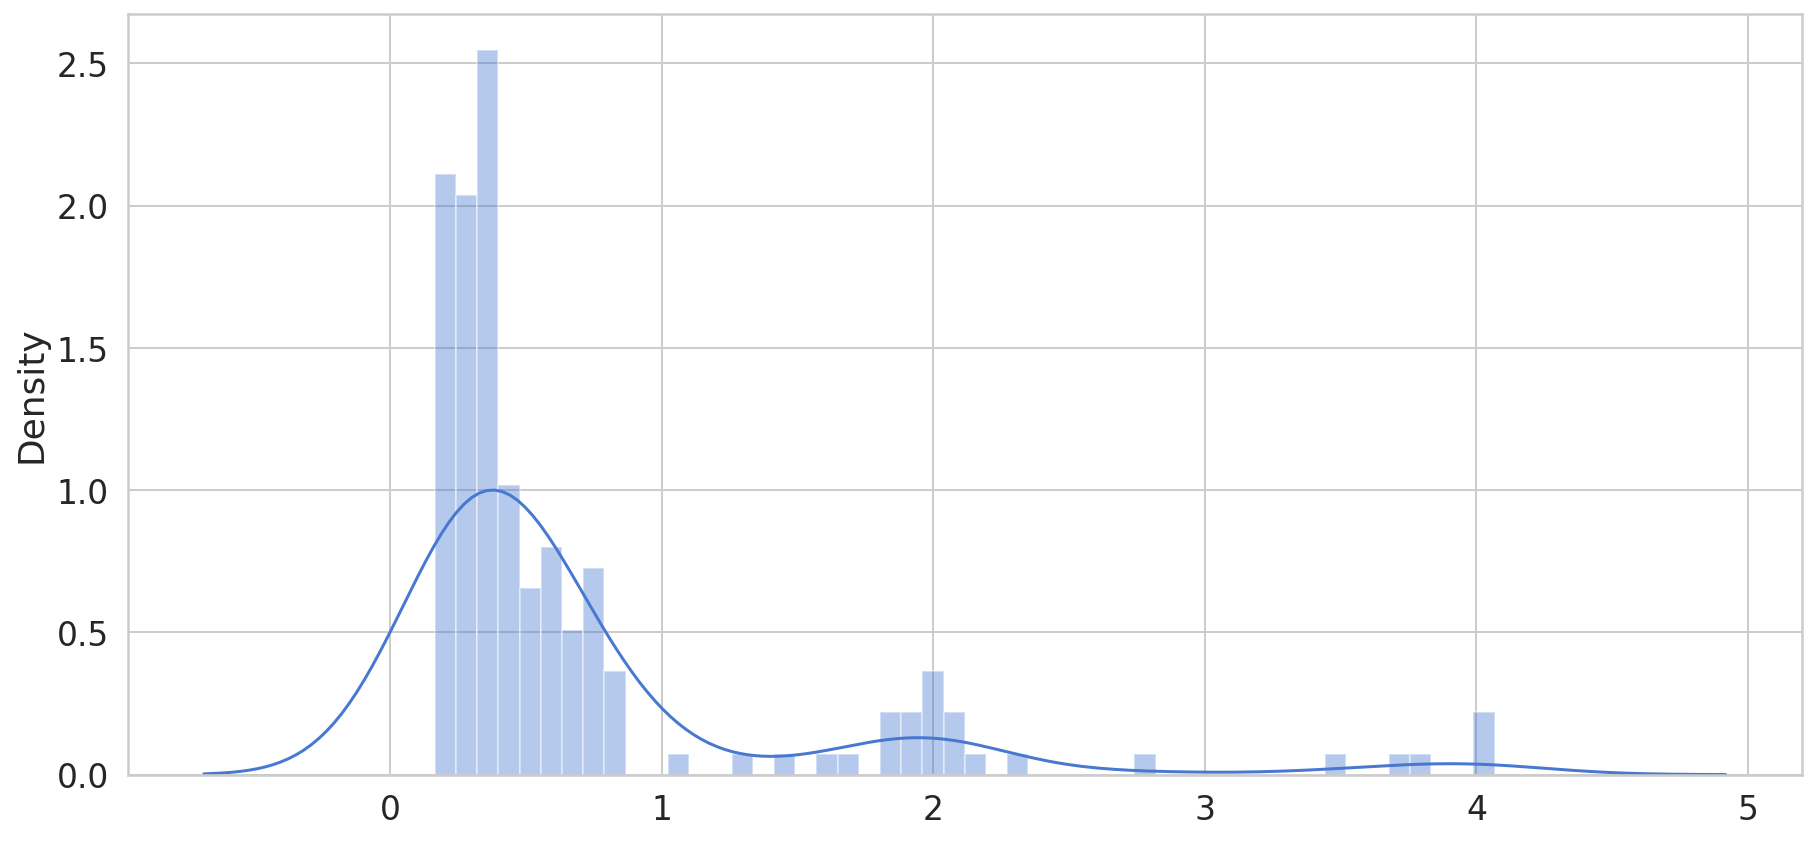

In [34]:
sns.distplot(train_mae_loss, bins=50, kde=True)

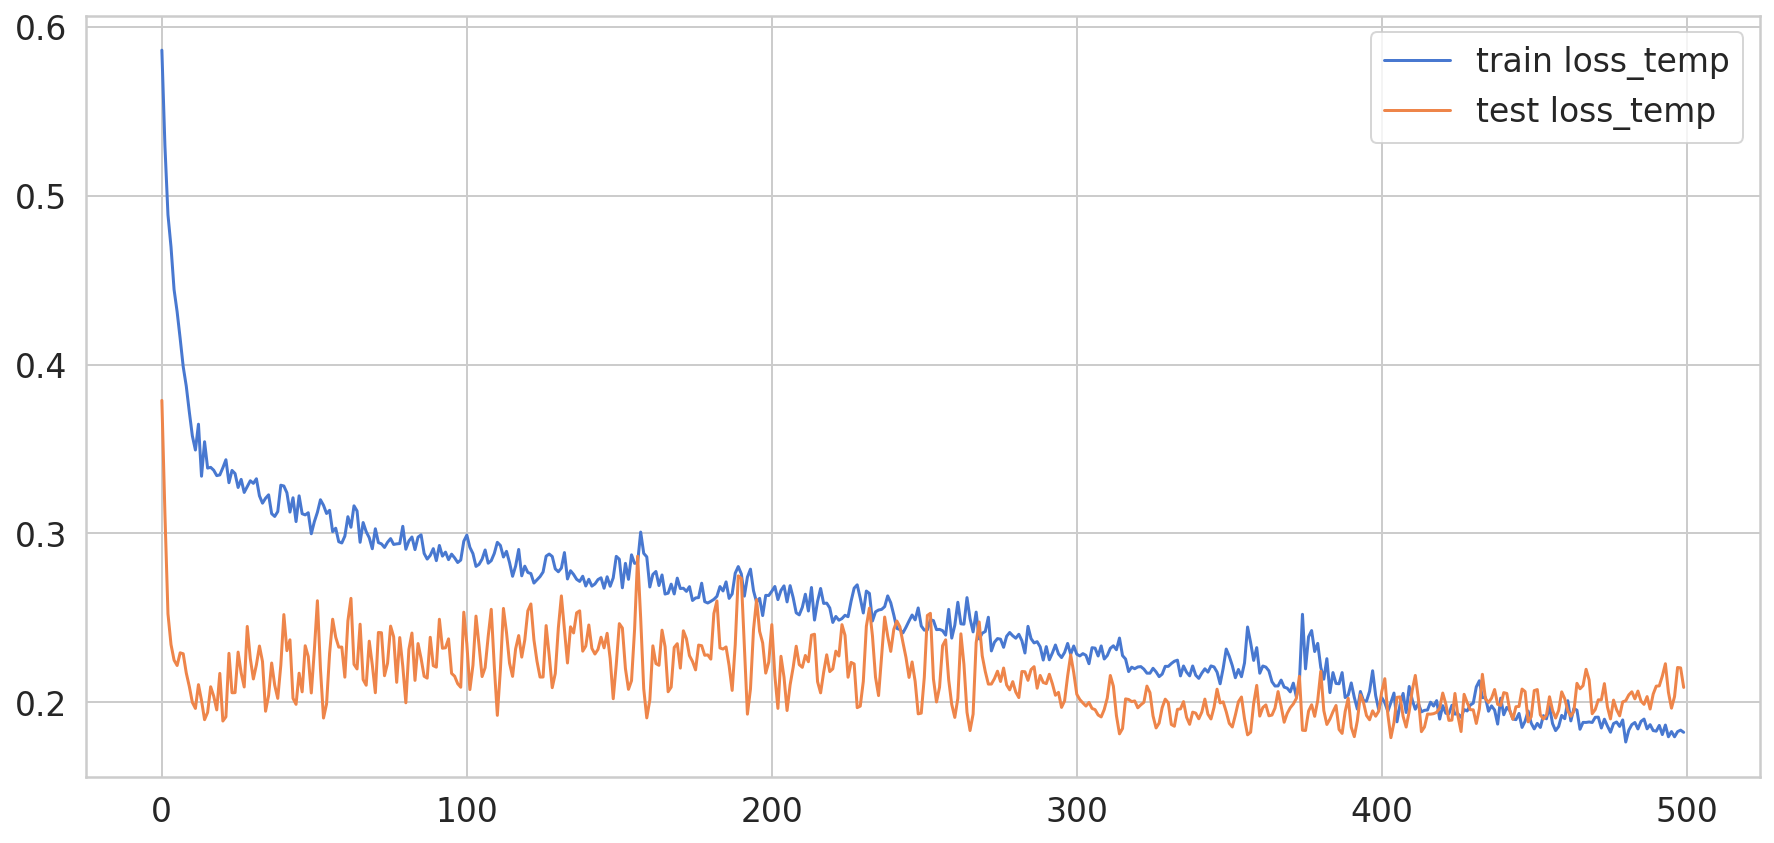

In [35]:
loss_plot()

                         loss  threshold  anomaly      temp
Time                                                       
2020-01-19 10:00:00  3.462230        3.1     True -3.274848
2020-01-19 11:00:00  3.806441        3.1     True -3.836741
2020-01-19 12:00:00  3.990327        3.1     True -4.265956
2020-01-19 13:00:00  4.066899        3.1     True -4.598260
2020-01-19 14:00:00  4.050082        3.1     True -4.861006
2020-01-19 15:00:00  3.752478        3.1     True -4.821381
2020-01-26 00:00:00  3.308393        3.1     True -3.332004
2020-01-26 01:00:00  3.568188        3.1     True -3.898407
2020-01-26 02:00:00  3.748808        3.1     True -4.265653
2020-01-26 03:00:00  3.646370        3.1     True -4.510806


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


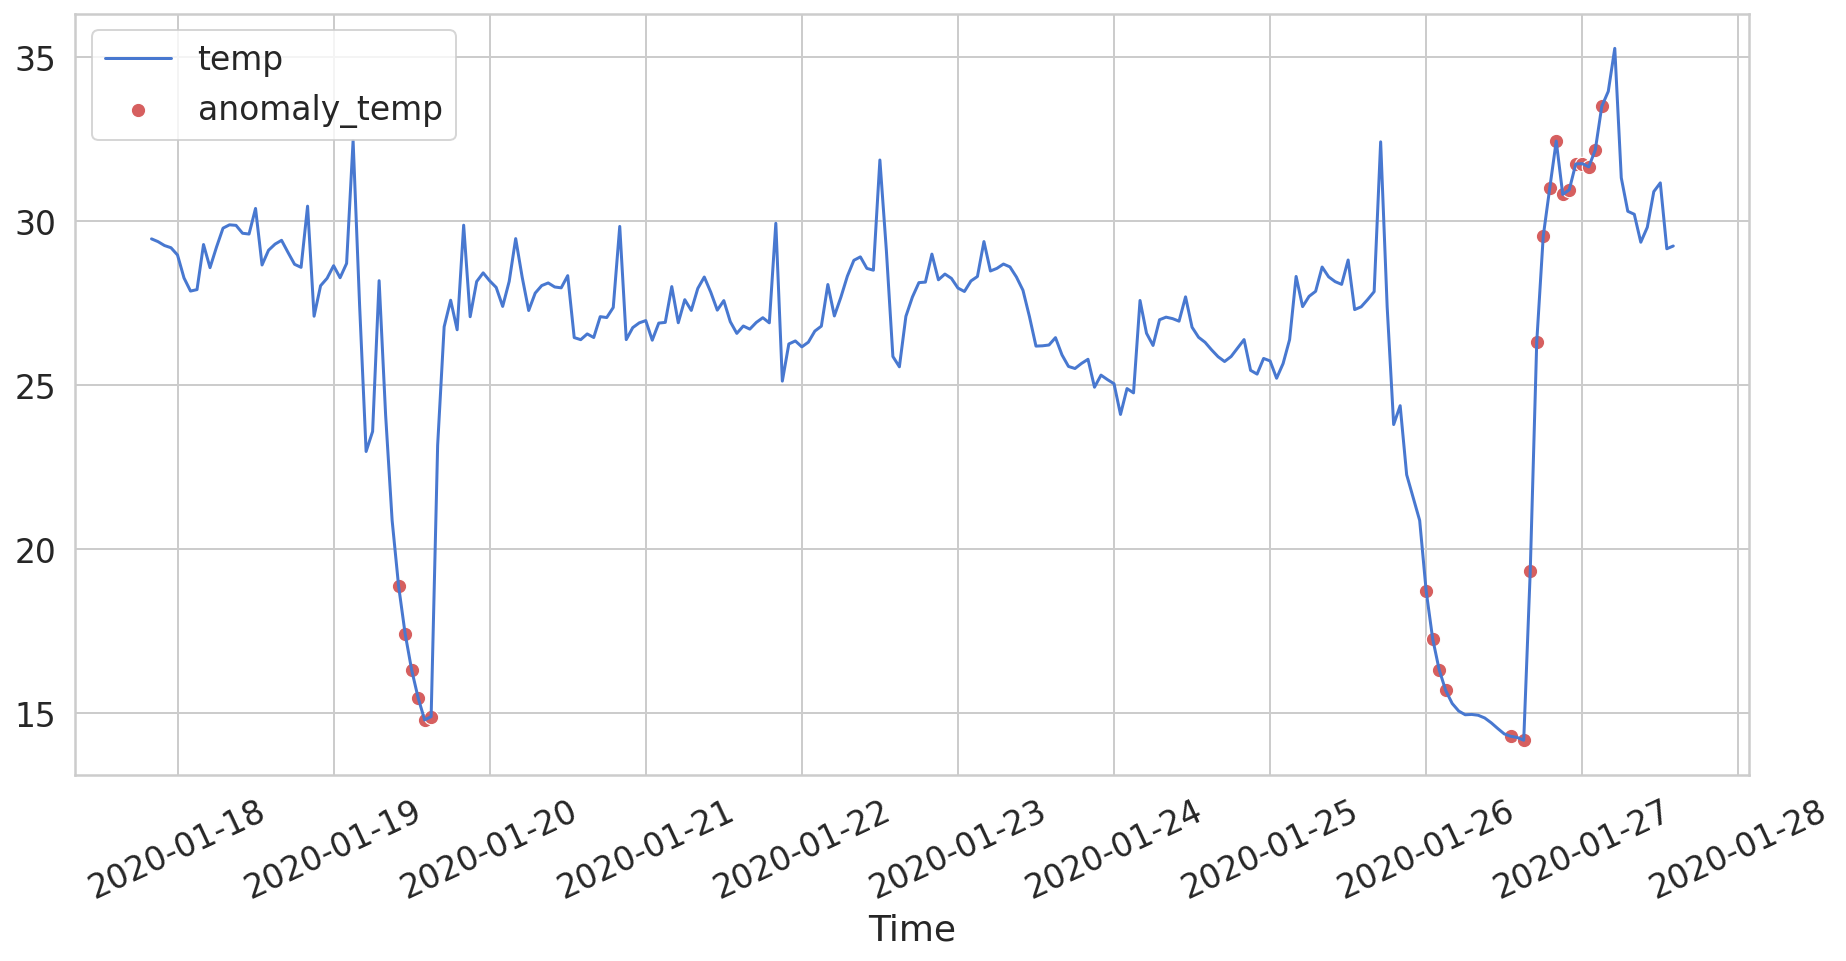

In [36]:
anomaly_plot(test,anomalies=anomalies)

# zacc

In [37]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="zacc",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

zacc**************************************************
(196, 1) (255, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(176, 20, 1)
Epoch 1/500
5/5 [==============================] - 3s 163ms/step - loss: 0.7068 - val_loss: 0.1480
Epoch 2/500
5/5 [==============================] - 0s 14ms/step - loss: 0.6337 - val_loss: 0.1746
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5969 - val_loss: 0.1842
Epoch 4/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5815 - val_loss: 0.1693
Epoch 5/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5761 - val_loss: 0.1626
Epoch 6/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5595 - val_loss: 0.1672
Epoch 7/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5503 - val_loss: 0.1742
Epoch 8/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5259 - val_loss: 0.1719
Epoch 9/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5275 - val_loss: 0.1687
Epoch 10/500
5/5 [==============================] - 0s 16ms/step - loss: 0.5125 - val_loss: 0.1715
Epoch

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


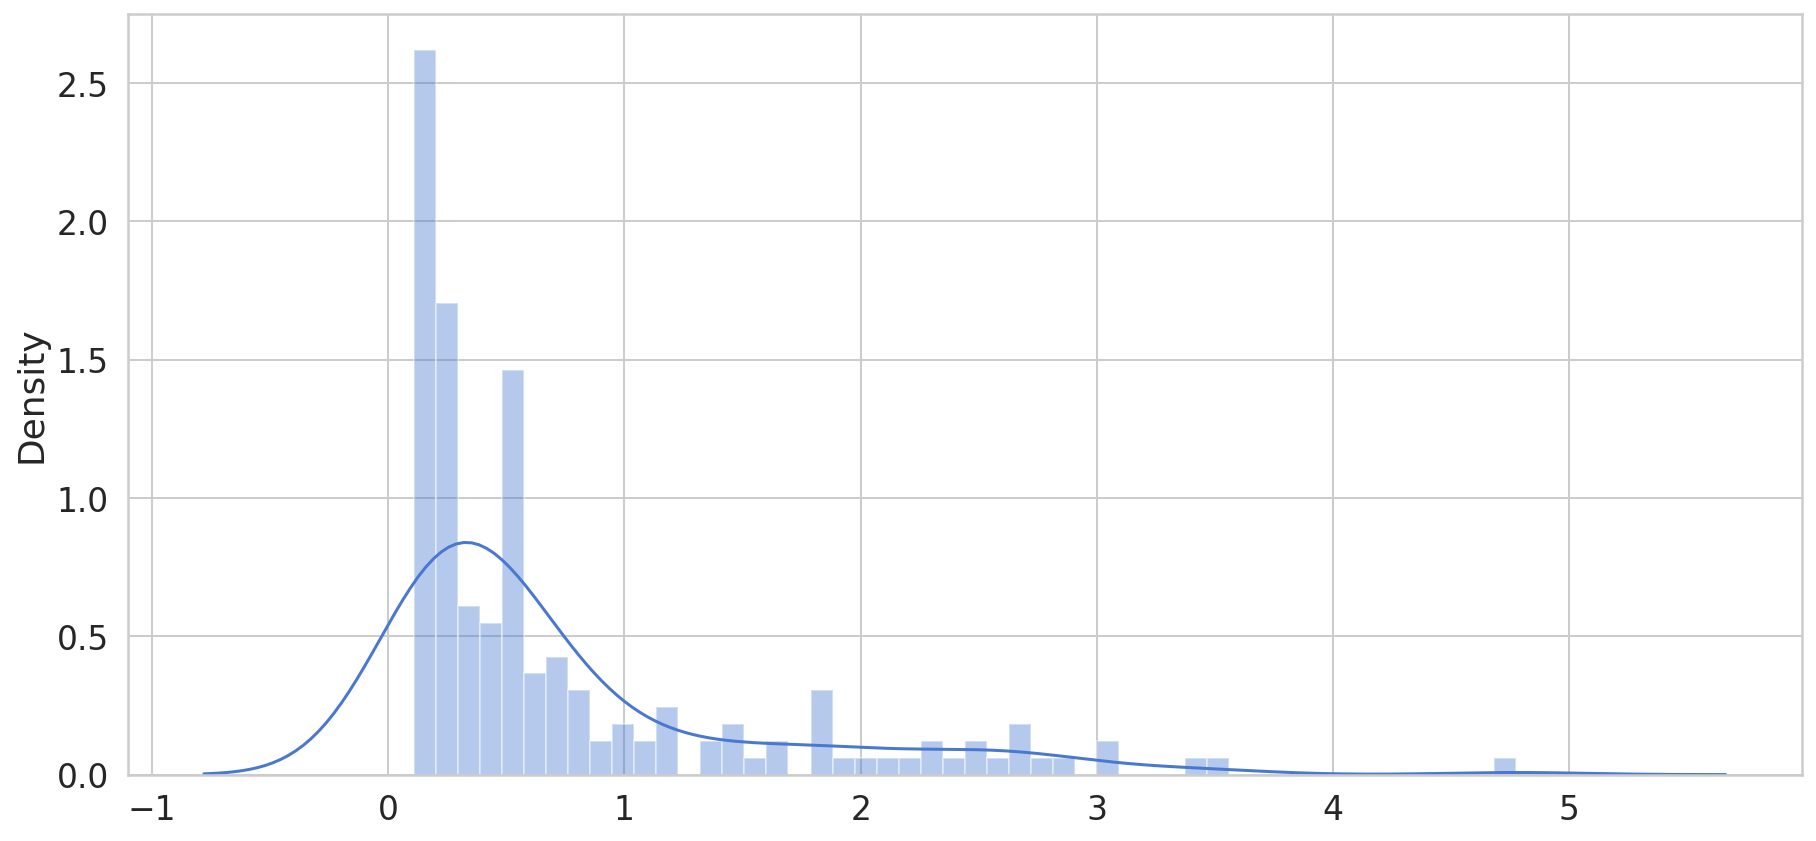

In [38]:
sns.distplot(train_mae_loss, bins=50, kde=True)

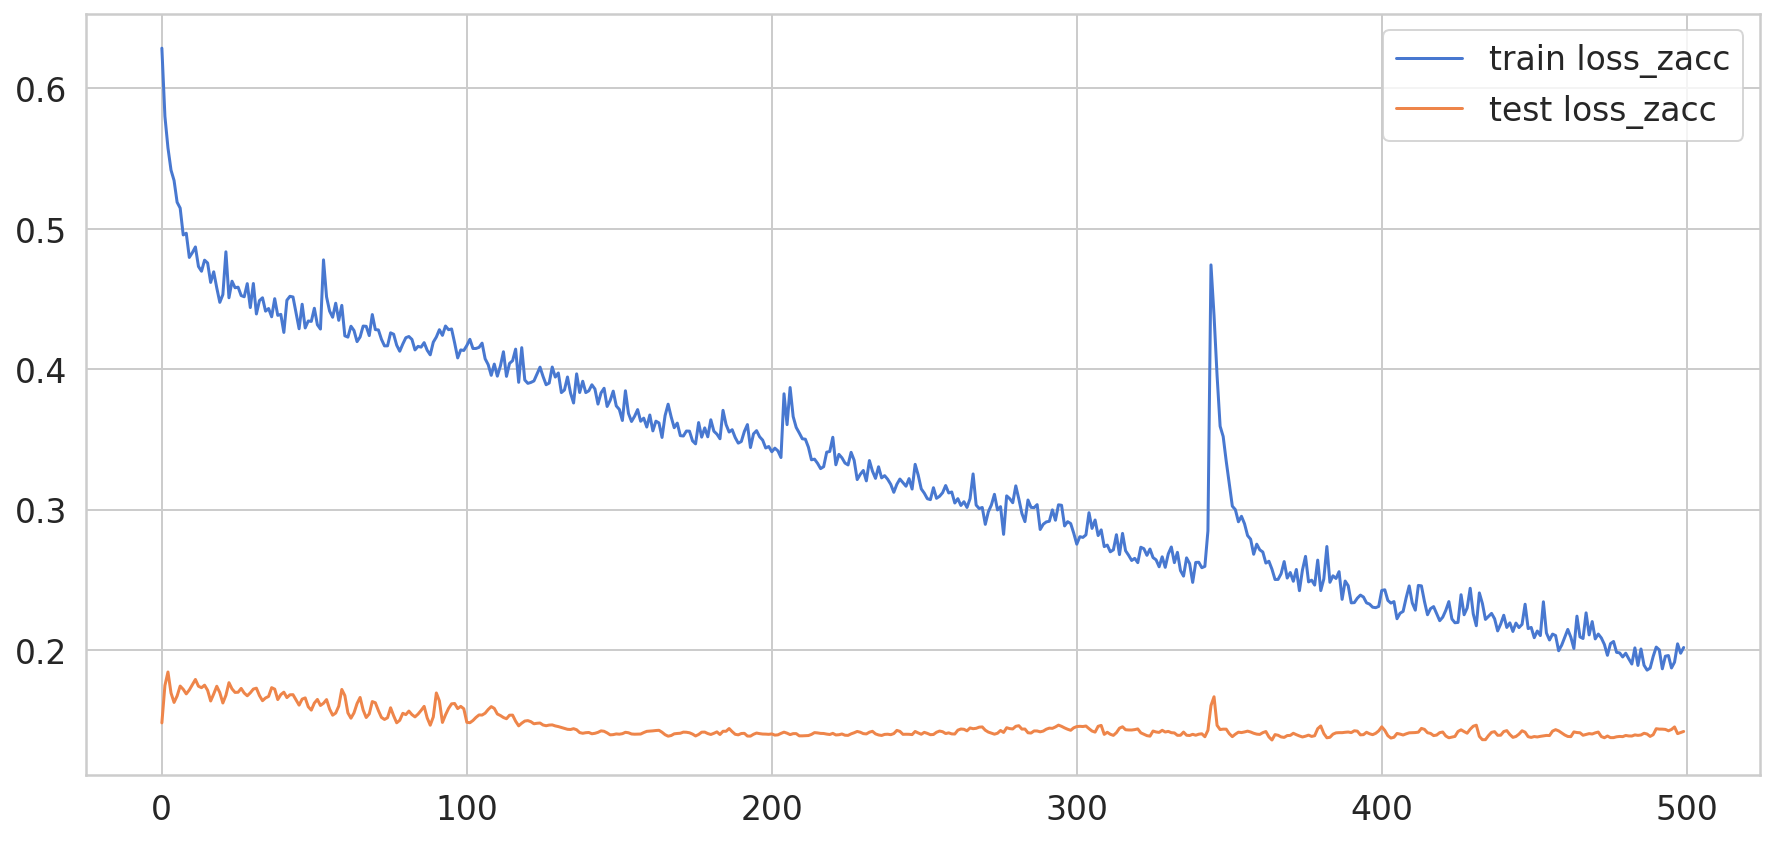

In [39]:
loss_plot()

                         loss  threshold  anomaly      zacc
Time                                                       
2020-01-19 04:00:00  3.421037        3.1     True -3.617905
2020-01-19 16:00:00  3.481278        3.1     True  1.666277
2020-01-19 19:00:00  4.772927        3.1     True  3.356645
2020-01-25 18:00:00  3.195777        3.1     True -3.772210
2020-01-26 06:00:00  3.392569        3.1     True -2.582749
2020-01-26 07:00:00  3.544073        3.1     True -2.872798
2020-01-26 08:00:00  3.456483        3.1     True -2.992956
2020-01-26 09:00:00  3.517666        3.1     True -2.839901
2020-01-26 10:00:00  3.529248        3.1     True -2.827023
2020-01-26 11:00:00  3.402339        3.1     True -3.193855


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


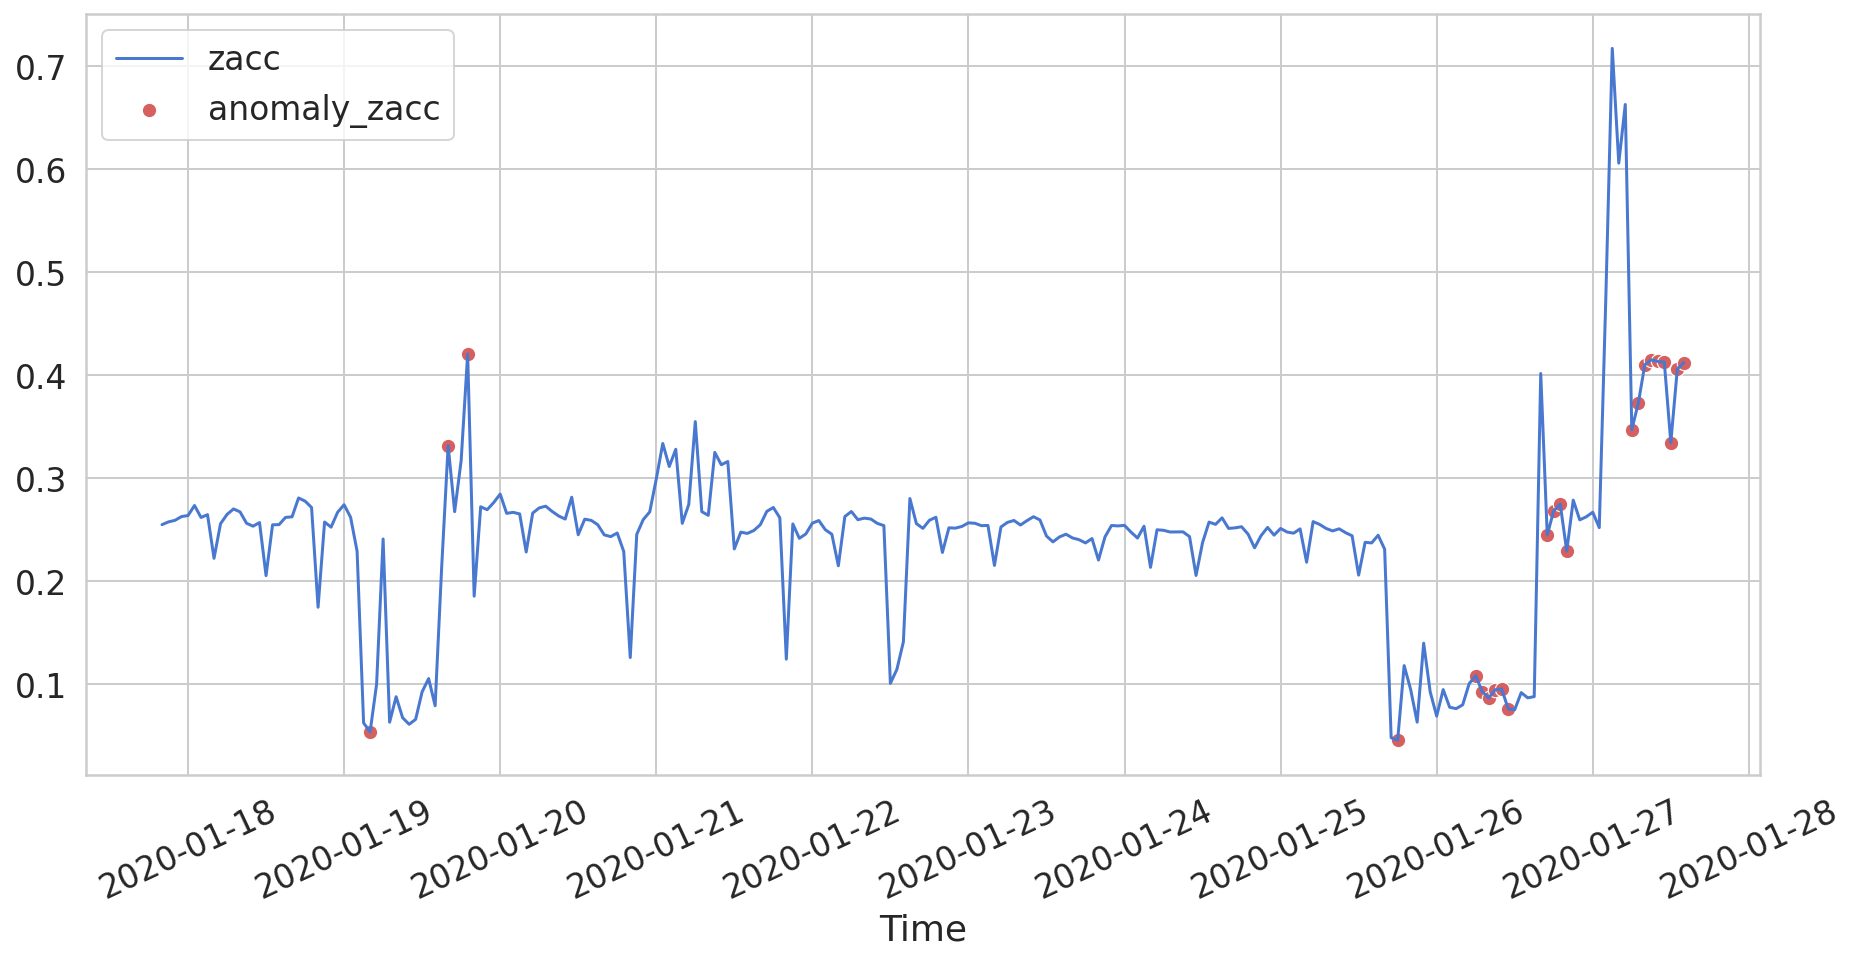

In [40]:
anomaly_plot(test,anomalies=anomalies)

# crest

In [41]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="crest",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

crest**************************************************
(196, 1) (255, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(176, 20, 1)
Epoch 1/500
5/5 [==============================] - 3s 163ms/step - loss: 0.5970 - val_loss: 0.1745
Epoch 2/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5030 - val_loss: 0.1397
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4949 - val_loss: 0.1112
Epoch 4/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4596 - val_loss: 0.1228
Epoch 5/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4250 - val_loss: 0.1104
Epoch 6/500
5/5 [==============================] - 0s 16ms/step - loss: 0.4197 - val_loss: 0.1062
Epoch 7/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4005 - val_loss: 0.1060
Epoch 8/500
5/5 [==============================] - 0s 14ms/step - loss: 0.3947 - val_loss: 0.1197
Epoch 9/500
5/5 [==============================] - 0s 14ms/step - loss: 0.3852 - val_loss: 0.1129
Epoch 10/500
5/5 [==============================] - 0s 17ms/step - loss: 0.3770 - val_loss: 0.0987
Epoch

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


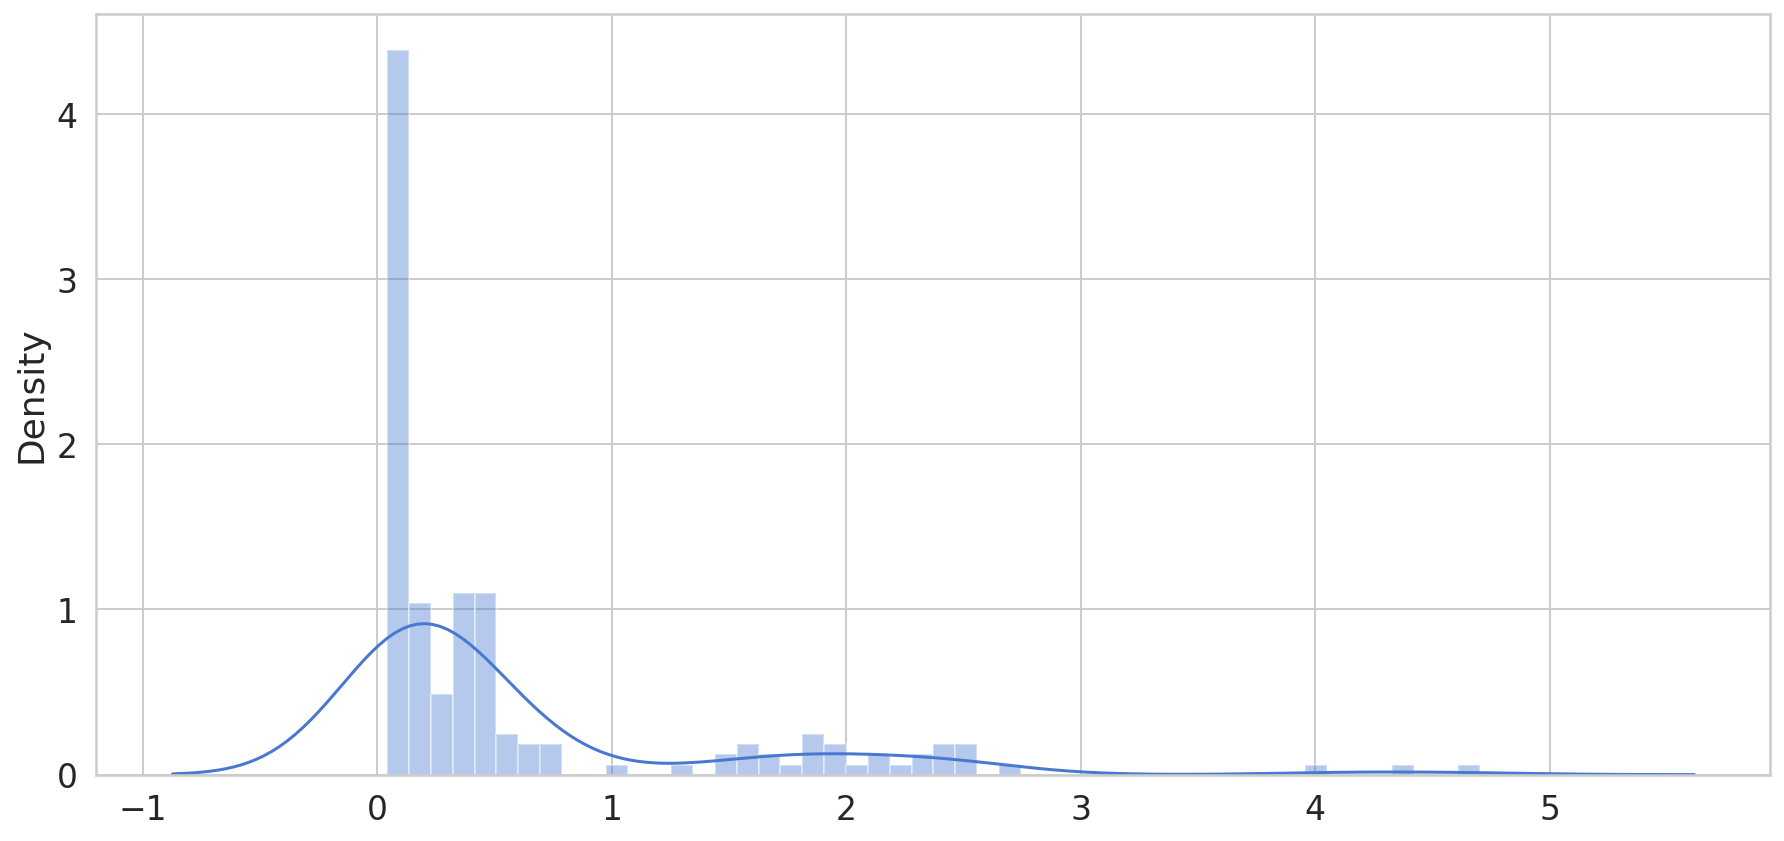

In [42]:
sns.distplot(train_mae_loss, bins=50, kde=True)

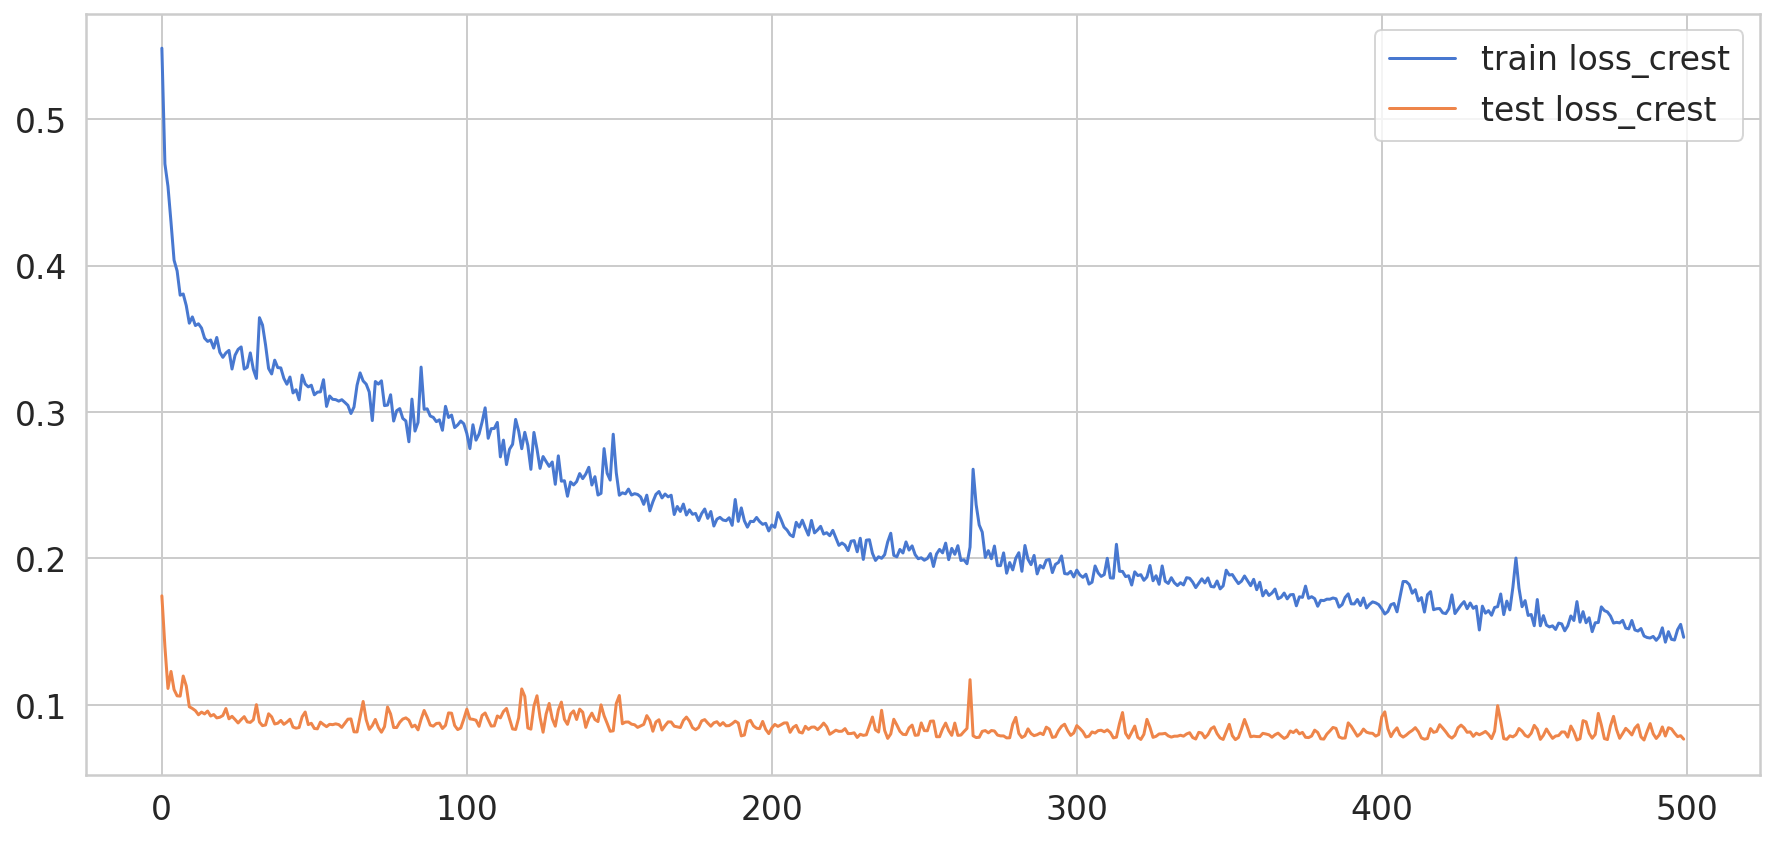

In [43]:
loss_plot()

                         loss  threshold  anomaly     crest
Time                                                       
2020-01-19 08:00:00  4.335821        3.1     True  4.794238
2020-01-19 12:00:00  4.048035        3.1     True  5.080041
2020-01-19 13:00:00  4.701919        3.1     True  6.162305
2020-01-26 13:00:00  3.428567        3.1     True  4.309119
2020-01-26 17:00:00  4.135698        3.1     True -0.509433
2020-01-26 18:00:00  4.122151        3.1     True -0.492361
2020-01-26 19:00:00  3.496086        3.1     True -0.444084
2020-01-26 20:00:00  3.237278        3.1     True  0.449429
2020-01-26 21:00:00  3.433875        3.1     True -0.381597
2020-01-26 22:00:00  3.454575        3.1     True -0.564350


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


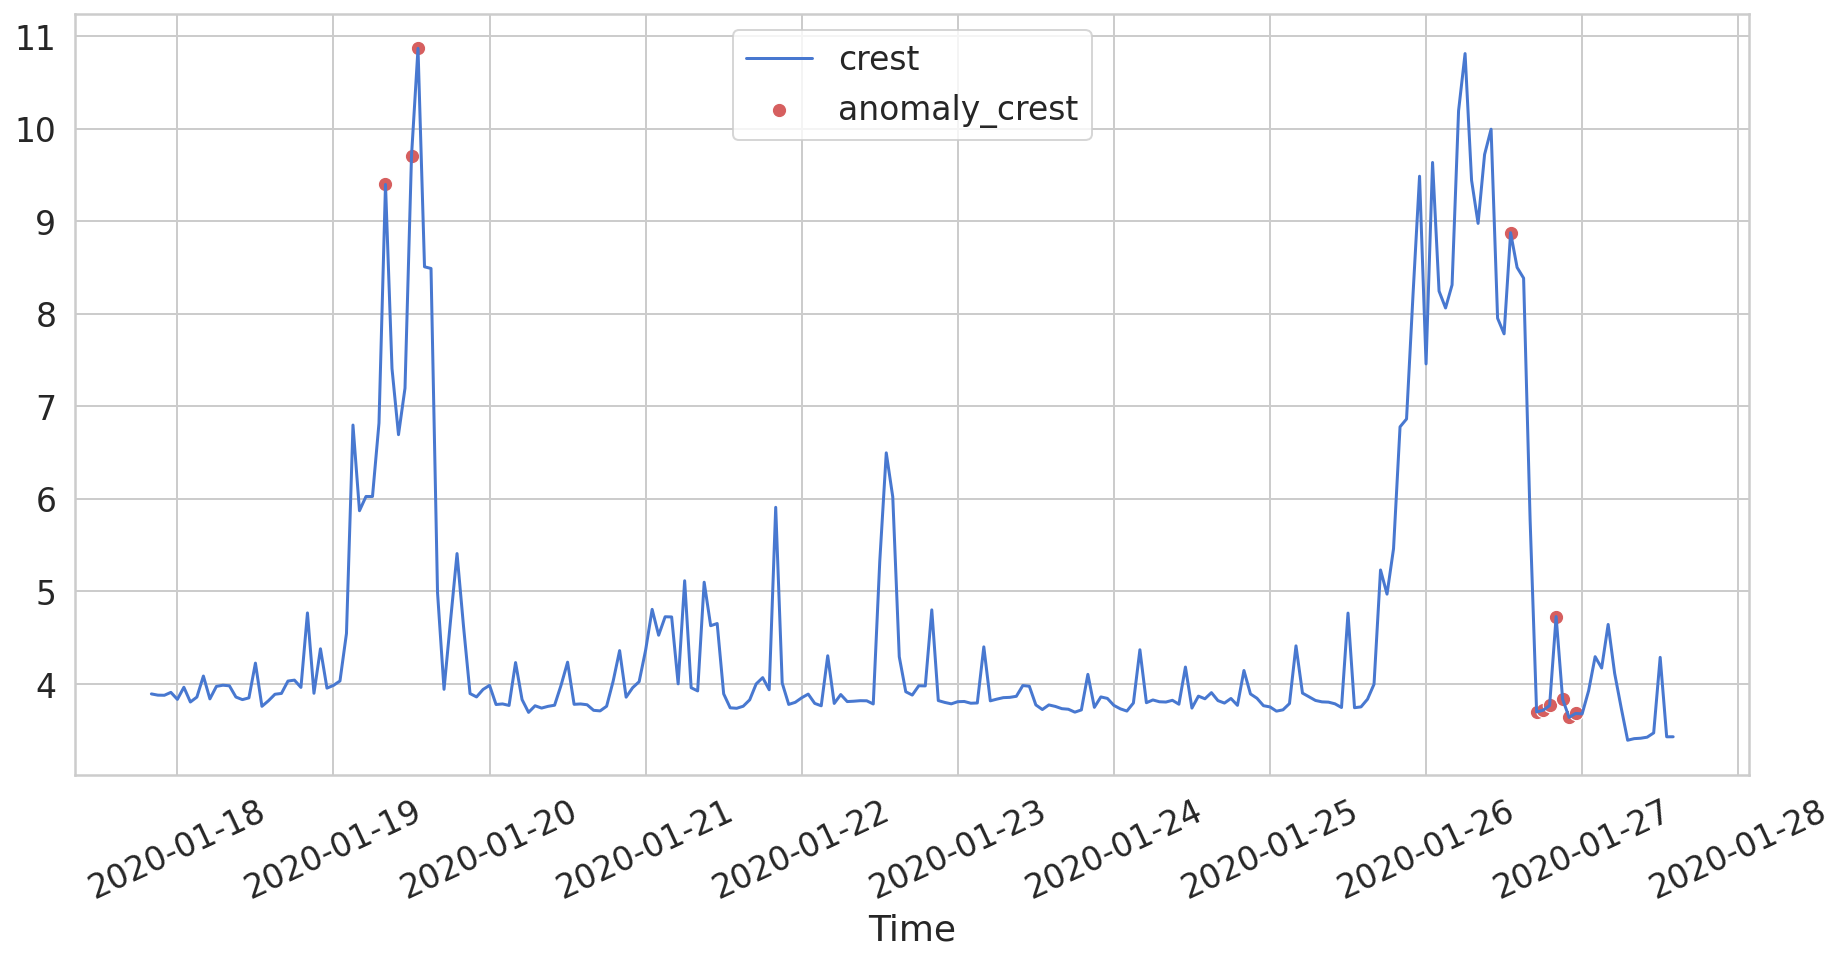

In [44]:
anomaly_plot(test,anomalies=anomalies)

# zfreq

In [45]:
anomalies,anomalies_train,test,train,test_score_df,test_mae_loss,train_mae_loss,history,TIME_STEPS,col,scaler= lstm_anomaly(df,col="zfreq",date="2020-01-25 04:00:00",time_step=20,threshold=3.1)
anomalyy= anomalies.reset_index()
anomalyy["anomaly_count"]=[1 for i in range(anomalies.shape[0])]
total_anomalies = pd.concat((total_anomalies,anomalyy),axis=0)

zfreq**************************************************
(196, 1) (255, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(176, 20, 1)
Epoch 1/500
5/5 [==============================] - 3s 167ms/step - loss: 0.7000 - val_loss: 0.2400
Epoch 2/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5740 - val_loss: 0.2369
Epoch 3/500
5/5 [==============================] - 0s 14ms/step - loss: 0.5494 - val_loss: 0.2172
Epoch 4/500
5/5 [==============================] - 0s 15ms/step - loss: 0.5061 - val_loss: 0.2157
Epoch 5/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4880 - val_loss: 0.2122
Epoch 6/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4636 - val_loss: 0.2154
Epoch 7/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4503 - val_loss: 0.2107
Epoch 8/500
5/5 [==============================] - 0s 16ms/step - loss: 0.4369 - val_loss: 0.2085
Epoch 9/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4372 - val_loss: 0.2053
Epoch 10/500
5/5 [==============================] - 0s 14ms/step - loss: 0.4205 - val_loss: 0.2067
Epoch

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


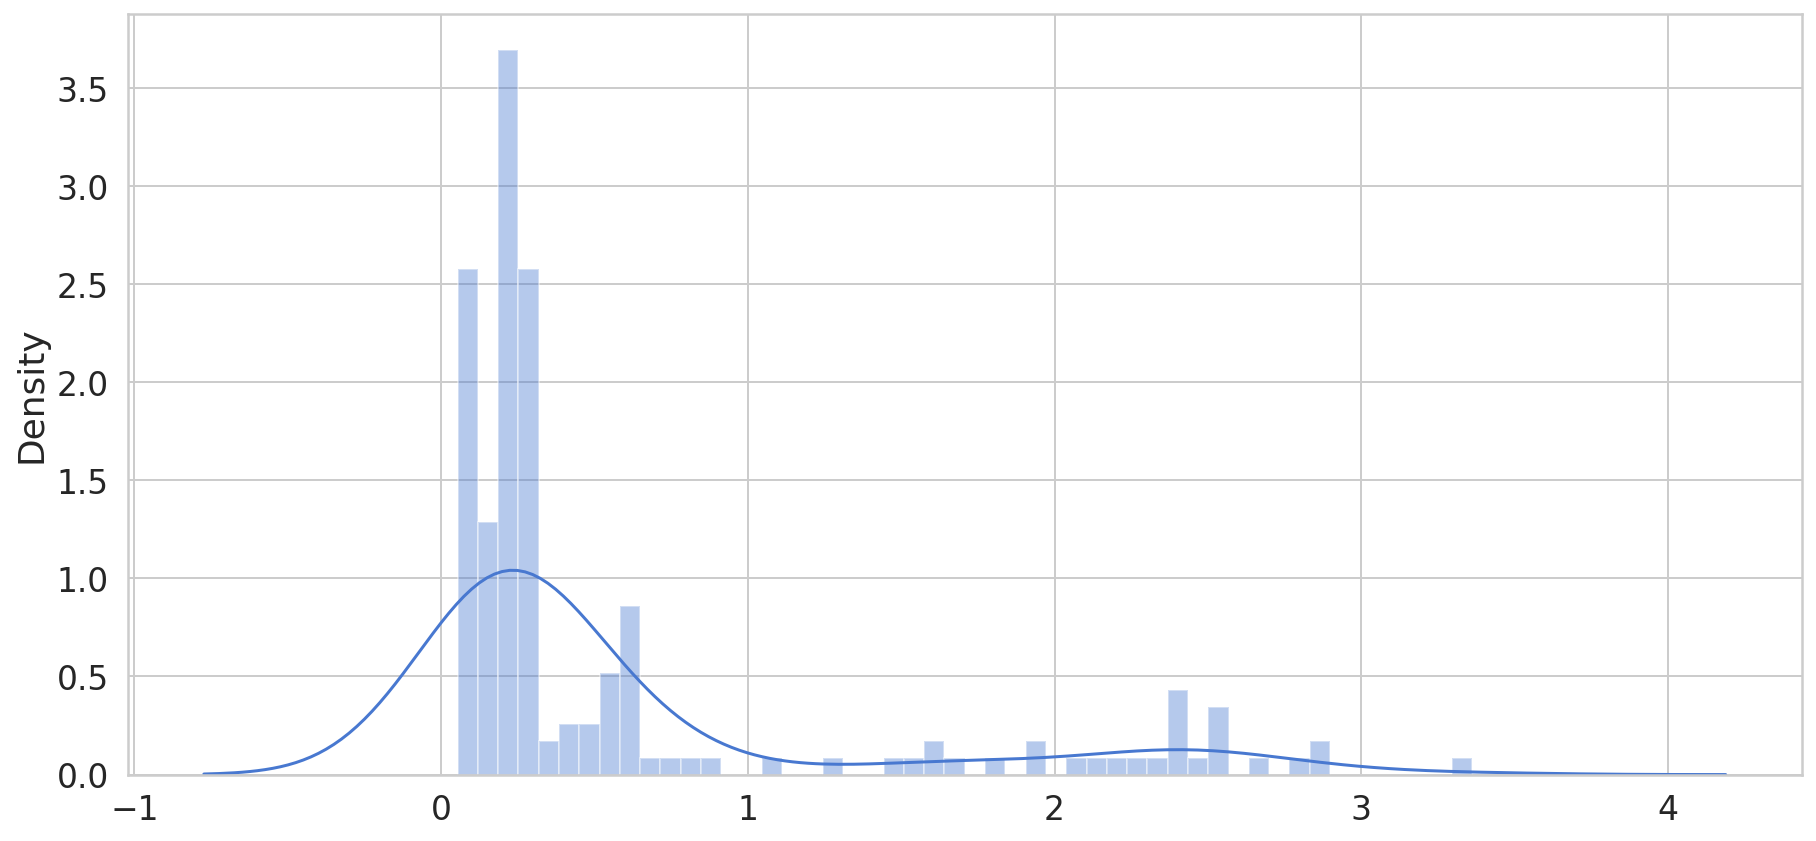

In [46]:
sns.distplot(train_mae_loss, bins=50, kde=True)

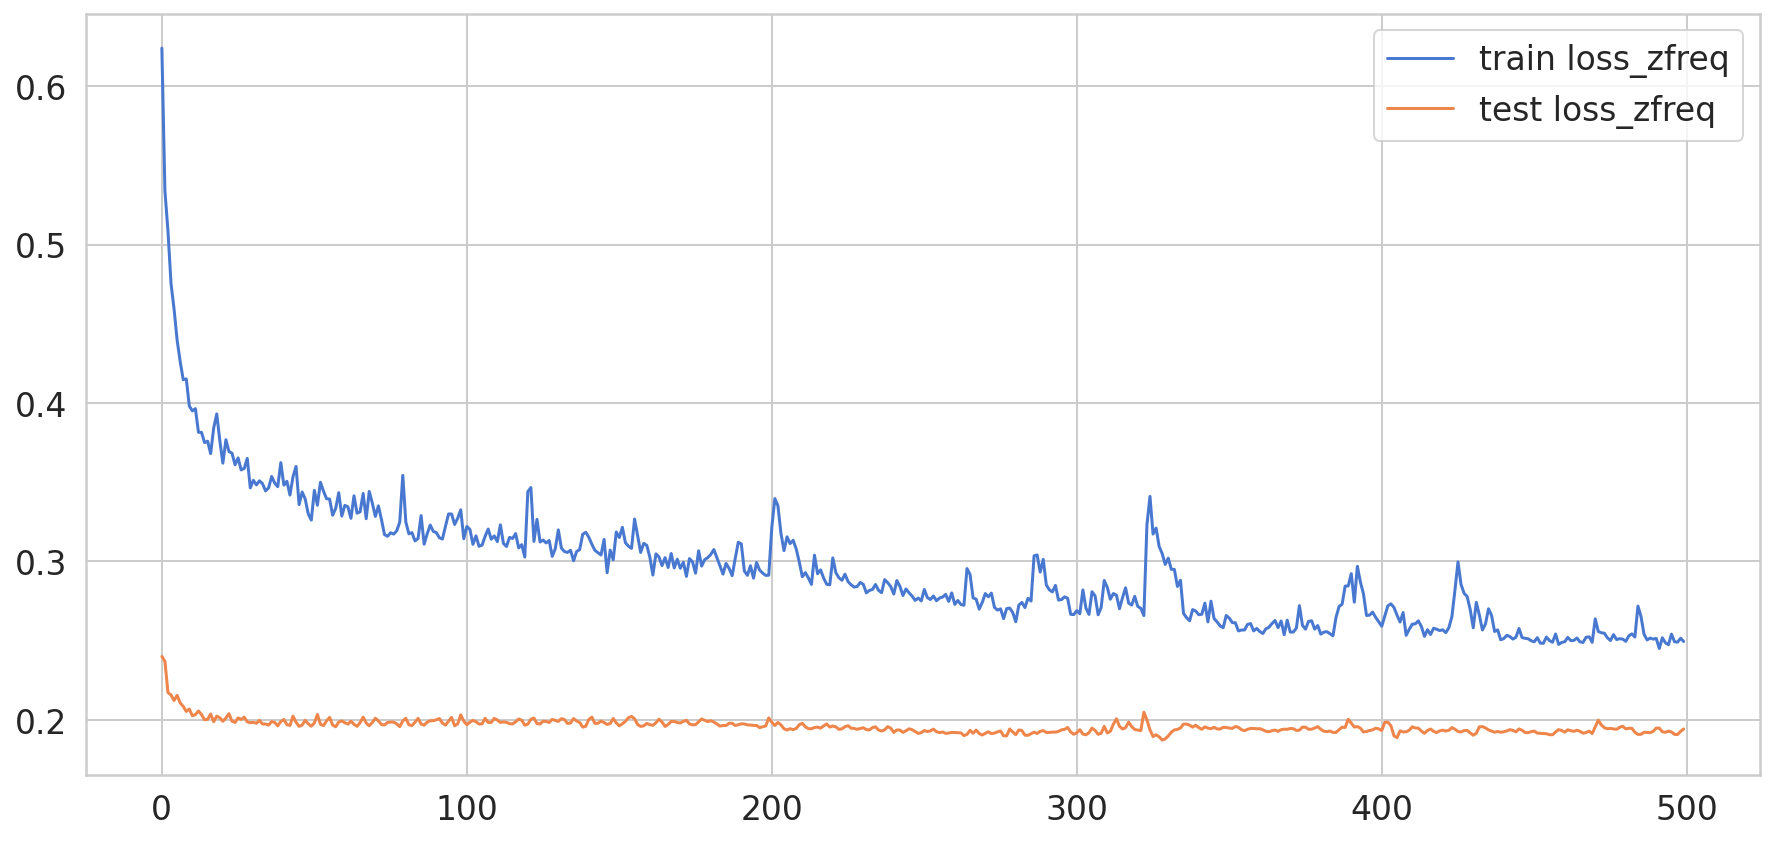

In [47]:
loss_plot()

                         loss  threshold  anomaly     zfreq
Time                                                       
2020-01-19 04:00:00  3.361129        3.1     True -3.447845
2020-01-25 18:00:00  3.229293        3.1     True -3.447845
2020-01-26 17:00:00  3.658379        3.1     True  0.231200
2020-01-26 18:00:00  3.512455        3.1     True  0.705166
2020-01-26 19:00:00  3.361861        3.1     True  0.579868
2020-01-26 20:00:00  3.164148        3.1     True -0.618062


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


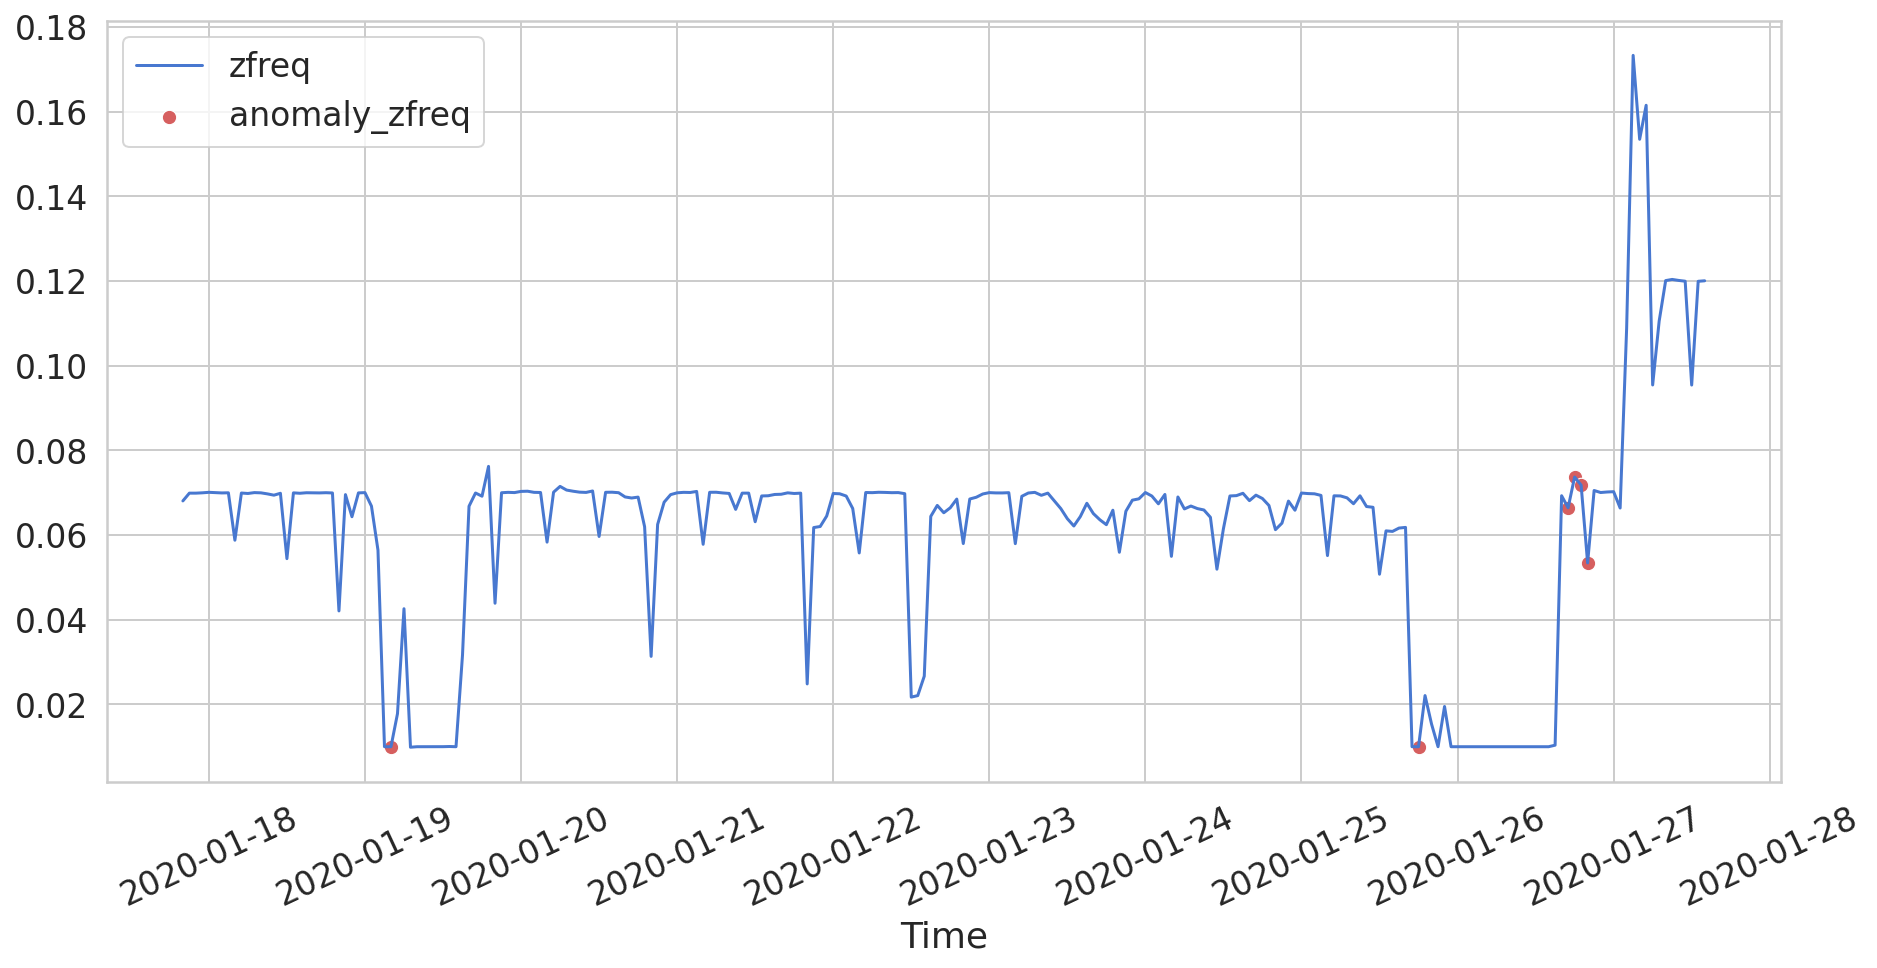

In [48]:
anomaly_plot(test,anomalies=anomalies)

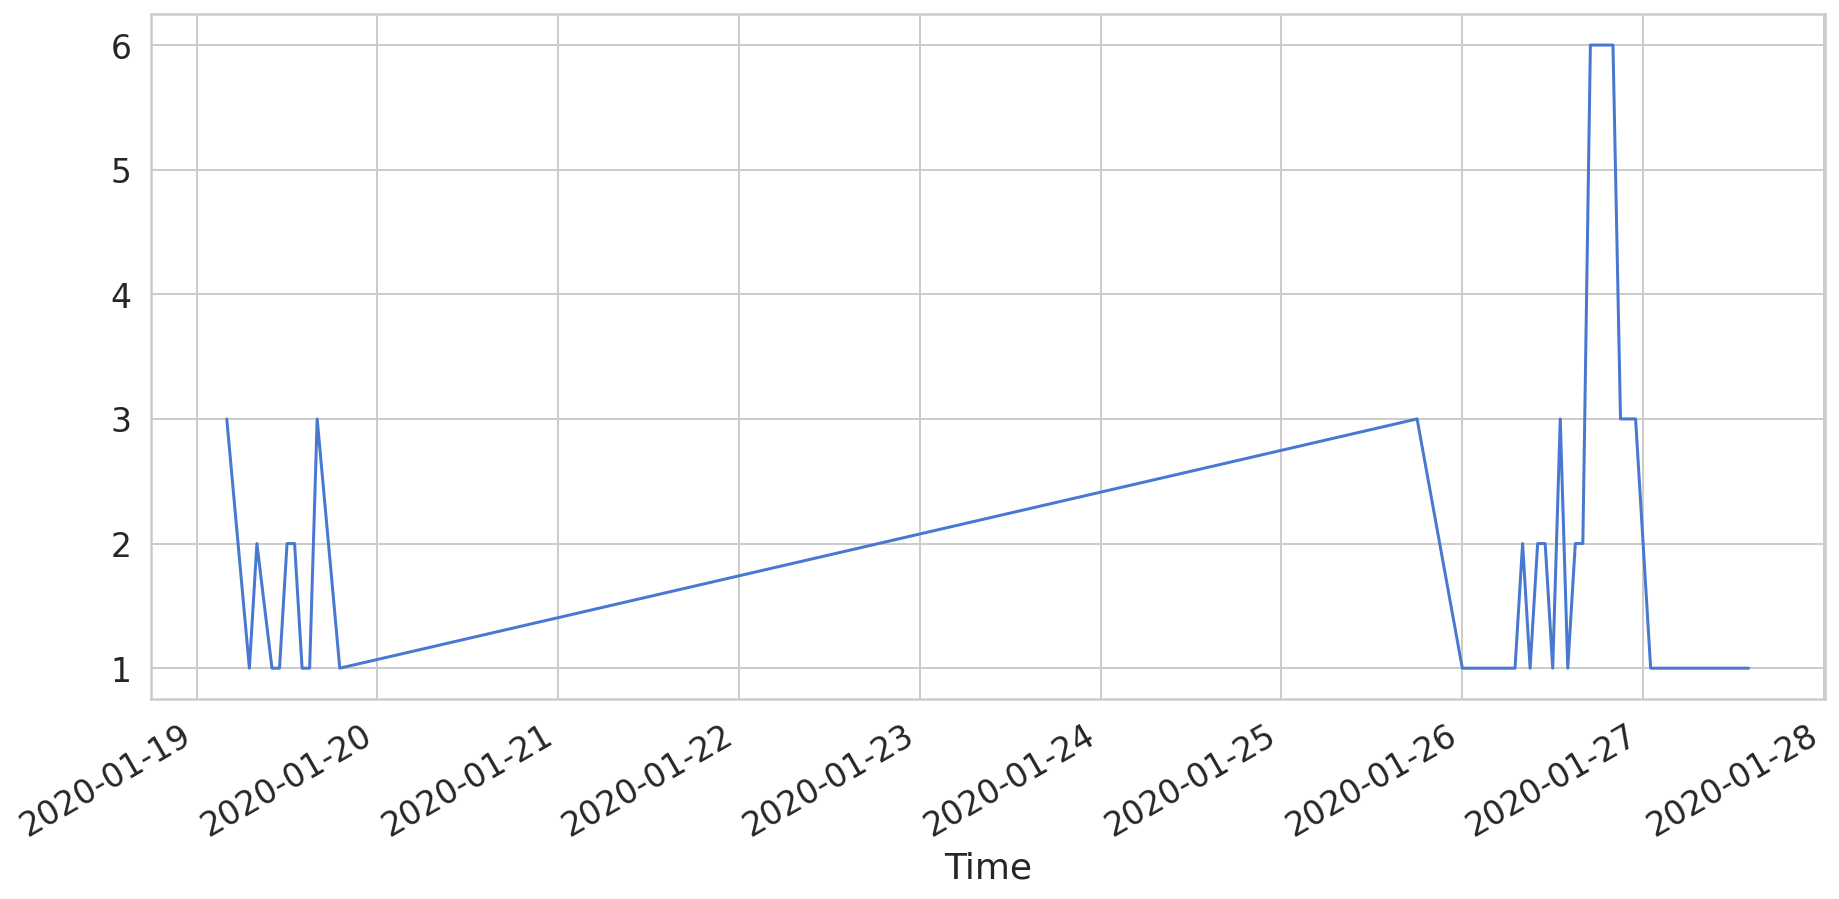

In [49]:
total_anomalies.groupby("Time")["anomaly_count"].sum().plot()

In [50]:
total_anomalies["Time"].value_counts()

2020-01-26 18:00:00    6
2020-01-26 17:00:00    6
2020-01-26 19:00:00    6
2020-01-26 20:00:00    6
2020-01-26 22:00:00    3
2020-01-26 23:00:00    3
2020-01-26 13:00:00    3
2020-01-19 16:00:00    3
2020-01-26 21:00:00    3
2020-01-25 18:00:00    3
2020-01-19 04:00:00    3
2020-01-26 10:00:00    2
2020-01-19 13:00:00    2
2020-01-27 00:00:00    2
2020-01-26 16:00:00    2
2020-01-26 11:00:00    2
2020-01-26 15:00:00    2
2020-01-19 08:00:00    2
2020-01-26 08:00:00    2
2020-01-19 12:00:00    2
2020-01-27 11:00:00    1
2020-01-27 03:00:00    1
2020-01-27 14:00:00    1
2020-01-26 09:00:00    1
2020-01-27 01:00:00    1
2020-01-27 07:00:00    1
2020-01-27 09:00:00    1
2020-01-26 02:00:00    1
2020-01-26 01:00:00    1
2020-01-27 02:00:00    1
2020-01-27 10:00:00    1
2020-01-27 08:00:00    1
2020-01-27 06:00:00    1
2020-01-19 19:00:00    1
2020-01-19 15:00:00    1
2020-01-26 00:00:00    1
2020-01-19 11:00:00    1
2020-01-26 07:00:00    1
2020-01-27 12:00:00    1
2020-01-26 06:00:00    1


In [51]:
total_anomalies.to_csv("total_anomaly.csv")